<center><font size=6> Bank Churn Prediction </font></center>

## Problem Statement

### Context

Businesses like banks which provide service have to worry about problem of 'Customer Churn' i.e. customers leaving and joining another service provider. It is important to understand which aspects of the service influence a customer's decision in this regard. Management can concentrate efforts on improvement of service, keeping in mind these priorities.

### Objective

You as a Data scientist with the  bank need to  build a neural network based classifier that can determine whether a customer will leave the bank  or not in the next 6 months.

### Data Dictionary

* CustomerId: Unique ID which is assigned to each customer

* Surname: Last name of the customer

* CreditScore: It defines the credit history of the customer.
  
* Geography: A customer’s location
   
* Gender: It defines the Gender of the customer
   
* Age: Age of the customer
    
* Tenure: Number of years for which the customer has been with the bank

* NumOfProducts: refers to the number of products that a customer has purchased through the bank.

* Balance: Account balance

* HasCrCard: It is a categorical variable which decides whether the customer has credit card or not.

* EstimatedSalary: Estimated salary

* isActiveMember: Is is a categorical variable which decides whether the customer is active member of the bank or not ( Active member in the sense, using bank products regularly, making transactions etc )

* Exited : whether or not the customer left the bank within six month. It can take two values
** 0=No ( Customer did not leave the bank )
** 1=Yes ( Customer left the bank )

## Importing necessary libraries

In [140]:
# Libraries to help with reading and manipulating data
import pandas as pd
import numpy as np

# Libaries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Library to split data
from sklearn.model_selection import train_test_split

# Library to import to standardize the data
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Importing different functions to build models
import tensorflow as tf
from tensorflow import keras
from keras import backend
from keras.models import Sequential
from keras.layers import Dense, Dropout

# Importing SMOTE
from imblearn.over_sampling import SMOTE

# Importing metrics
from sklearn.metrics import confusion_matrix,roc_curve,classification_report,recall_score

import random

# Library to avoid the warnings
import warnings
warnings.filterwarnings("ignore")

## Google colab library to access Google Drive.
#from google.colab import drive
#drive.mount('/content/drive/')

## Define Functions

#### EDA Functions

In [141]:
# function to plot a boxplot and a histogram along the same scale.


def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a triangle will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

In [142]:
# function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

In [143]:
# function to plot stacked bar chart

def stacked_barplot(data, predictor, target, n=None):
    """
    Print the category counts and plot a stacked bar chart

    data: dataframe
    predictor: independent variable
    target: target variable
    """
    count = data[predictor].nunique()
    sorter = data[target].value_counts().index[-1]
    tab1 = pd.crosstab(data[predictor], data[target], margins=True).sort_values(
        by=sorter, ascending=False
    )
    print(tab1)
    print("-" * 120)
    tab = pd.crosstab(data[predictor], data[target], normalize="index").sort_values(
        by=sorter, ascending=False
    )

    tab.plot(kind="bar", stacked=True, figsize=(count + 1, 5))
    plt.legend(
        loc="lower left", frameon=False,
    )
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.show()

In [144]:
### Function to plot distributions

def distribution_plot_wrt_target(data, predictor, target):

    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    target_uniq = data[target].unique()

    axs[0, 0].set_title("Distribution of target for target=" + str(target_uniq[0]))
    sns.histplot(
        data=data[data[target] == target_uniq[0]],
        x=predictor,
        kde=True,
        ax=axs[0, 0],
        color="teal",
    )

    axs[0, 1].set_title("Distribution of target for target=" + str(target_uniq[1]))
    sns.histplot(
        data=data[data[target] == target_uniq[1]],
        x=predictor,
        kde=True,
        ax=axs[0, 1],
        color="orange",
    )

    axs[1, 0].set_title("Boxplot w.r.t target")
    sns.boxplot(data=data, x=target, y=predictor, ax=axs[1, 0], palette="gist_rainbow")

    axs[1, 1].set_title("Boxplot (without outliers) w.r.t target")
    sns.boxplot(
        data=data,
        x=target,
        y=predictor,
        ax=axs[1, 1],
        showfliers=False,
        palette="gist_rainbow",
    )

    plt.tight_layout()
    plt.show()

### Pre-processing Functions

In [145]:
def outlier_detection(data):
  Q1 = data.quantile(0.25)  # To find the 25th percentile
  Q3 = data.quantile(0.75)  # To find the 75th percentile

  IQR = Q3 - Q1  # Inter Quantile Range (75th perentile - 25th percentile)

  # Finding lower and upper bounds for all values. All values outside these bounds are outliers
  lower = (Q1 - 1.5 * IQR)
  upper = (Q3 + 1.5 * IQR)

  # checking the % outliers
  print(((data.select_dtypes(include=["float64", "int64"]) < lower) | (data.select_dtypes(include=["float64", "int64"]) > upper)).sum() / len(data) * 100)

In [146]:
## Function to inverse encoding
def inverse_mapping(x, y):
    inv_dict = {v: k for k, v in x.items()}
    X_train[y] = np.round(X_train[y]).map(inv_dict).astype("category")
    X_val[y] = np.round(X_val[y]).map(inv_dict).astype("category")
    X_test[y] = np.round(X_test[y]).map(inv_dict).astype("category")

### Model Performance Metrics

In [147]:
## Function to create confusion matrix
def make_confusion_matrix(model,y_actual,labels=[1, 0]):
    '''
    model : classifier to predict values of X
    y_actual : ground truth

    '''
    y_predict = model.predict(X_test)
    cm=metrics.confusion_matrix( y_actual, y_predict, labels=[0, 1])
    df_cm = pd.DataFrame(cm, index = [i for i in ["Actual - No","Actual - Yes"]],
                  columns = [i for i in ['Predicted - No','Predicted - Yes']])
    group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}" for v1, v2 in
              zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    plt.figure(figsize = (10,7))
    sns.heatmap(df_cm, annot=labels,fmt='')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [148]:
# defining a function to compute different metrics to check performance of a classification model built using sklearn
def model_performance_classification_sklearn(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "Accuracy": acc,
            "Recall": recall,
            "Precision": precision,
            "F1": f1

        },
        index=[0],
    )

    return df_perf

## Loading the dataset

In [149]:
# Use pandas to load the csv file
churn_df = pd.read_csv("https://raw.githubusercontent.com/todd-wilson/portfolio/main/bank-churn-prediction/bank-churn.csv")
# Copy the original data frame
df = churn_df.copy()

## Data Overview

### First and Last Rows

In [150]:
df.tail()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1
9999,10000,15628319,Walker,792,France,Female,28,4,130142.79,1,1,0,38190.78,0


In [151]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


#### Observations
* Geography and Gender are categorical and will need to be treated.
* CustomerId and RowNumber are unique identifiers and will be dropped.
* Surname is a text column and will be dropped as I don't believe it is a good independent variable for bank churn.

### Data Summary

In [152]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


#### Observations
* There are 10,000 rows and 14 columns.
* Geography and Gender are object data types and will need to be treated.

#### Stat Summary

In [153]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
RowNumber,10000.0,5.000500e+03,2886.895680,1.00,2500.75,5.000500e+03,7.500250e+03,10000.00
CustomerId,10000.0,1.569094e+07,71936.186123,15565701.00,15628528.25,1.569074e+07,1.575323e+07,15815690.00
CreditScore,10000.0,6.505288e+02,96.653299,350.00,584.00,6.520000e+02,7.180000e+02,850.00
Age,10000.0,3.892180e+01,10.487806,18.00,32.00,3.700000e+01,4.400000e+01,92.00
Tenure,10000.0,5.012800e+00,2.892174,0.00,3.00,5.000000e+00,7.000000e+00,10.00
Balance,10000.0,7.648589e+04,62397.405202,0.00,0.00,9.719854e+04,1.276442e+05,250898.09
NumOfProducts,10000.0,1.530200e+00,0.581654,1.00,1.00,1.000000e+00,2.000000e+00,4.00
HasCrCard,10000.0,7.055000e-01,0.455840,0.00,0.00,1.000000e+00,1.000000e+00,1.00
IsActiveMember,10000.0,5.151000e-01,0.499797,0.00,0.00,1.000000e+00,1.000000e+00,1.00
EstimatedSalary,10000.0,1.000902e+05,57510.492818,11.58,51002.11,1.001939e+05,1.493882e+05,199992.48


##### Observations
* Estimated salary min of $11.50 is definitely an outlier.
* Oldest customer is 92 and youngest is 18.
* Nothing out of the ordinary.

### Drop Columns

* Surname is an identifier which would not be a good independent variable so it will be dropped.
* RowNumber and CustomerId are unique identifiers and will be dropped.

In [154]:
# Dropping columns
df = df.drop(['Surname', 'RowNumber', 'CustomerId'], axis=1)

# Verify the columns are gone.
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


### Duplicates and Nulls

In [155]:
df.duplicated().sum()

0

In [156]:
round(df.isnull().sum() / df.isnull().count() * 100, 2)

CreditScore        0.0
Geography          0.0
Gender             0.0
Age                0.0
Tenure             0.0
Balance            0.0
NumOfProducts      0.0
HasCrCard          0.0
IsActiveMember     0.0
EstimatedSalary    0.0
Exited             0.0
dtype: float64

#### Observations
* There are no duplicated rows.
* There are no NULL values.

### Column Value Analysis

In [157]:
# list all the unique values in the columsn to see if there is any dirty data
for col in df.columns:
  print(f'{col}: ', df[col].unique())

CreditScore:  [619 608 502 699 850 645 822 376 501 684 528 497 476 549 635 616 653 587
 726 732 636 510 669 846 577 756 571 574 411 591 533 553 520 722 475 490
 804 582 472 465 556 834 660 776 829 637 550 698 585 788 655 601 656 725
 511 614 742 687 555 603 751 581 735 661 675 738 813 657 604 519 664 678
 757 416 665 777 543 506 493 652 750 729 646 647 808 524 769 730 515 773
 814 710 413 623 670 622 785 605 479 685 538 562 721 628 668 828 674 625
 432 770 758 795 686 789 589 461 584 579 663 682 793 691 485 650 754 535
 716 539 706 586 631 717 800 683 704 615 667 484 480 578 512 606 597 778
 514 525 715 580 807 521 759 516 711 618 643 671 689 620 676 572 695 592
 567 694 547 594 673 610 767 763 712 703 662 659 523 772 545 634 739 771
 681 544 696 766 727 693 557 531 498 651 791 733 811 707 714 782 775 799
 602 744 588 747 583 627 731 629 438 642 806 474 559 429 680 749 734 644
 626 649 805 718 840 630 654 762 568 613 522 737 648 443 640 540 460 593
 801 611 802 745 483 690 492 709 705 

#### Observations
* No data that needs to be cleaned

### Column Frequency

In [158]:
# get columns
cat_col = df.columns

# Occurrences of each unique value in each categorical column sorted by most frequent
for column in cat_col:
    print(df[column].value_counts(normalize=True, sort=True))
    print("-" * 50)

850    0.0233
678    0.0063
655    0.0054
705    0.0053
667    0.0053
        ...  
404    0.0001
351    0.0001
365    0.0001
417    0.0001
419    0.0001
Name: CreditScore, Length: 460, dtype: float64
--------------------------------------------------
France     0.5014
Germany    0.2509
Spain      0.2477
Name: Geography, dtype: float64
--------------------------------------------------
Male      0.5457
Female    0.4543
Name: Gender, dtype: float64
--------------------------------------------------
37    0.0478
38    0.0477
35    0.0474
36    0.0456
34    0.0447
       ...  
92    0.0002
82    0.0001
88    0.0001
85    0.0001
83    0.0001
Name: Age, Length: 70, dtype: float64
--------------------------------------------------
2     0.1048
1     0.1035
7     0.1028
8     0.1025
5     0.1012
3     0.1009
4     0.0989
9     0.0984
6     0.0967
10    0.0490
0     0.0413
Name: Tenure, dtype: float64
--------------------------------------------------
0.00         0.3617
130170.82    0.0002
10

#### Observations
* 36.7% of customers have a zero balance.
* 96.7% of customers have less than three products.
* 70.5% of customers have a bank credit card.
* 48.5% of customers are inactive. This is significant.

### Dependent Variable Analysis

In [159]:
#checking the percentage of the dependent variable (y) in the dataset
(df.Exited.value_counts())/(df.Exited.count())

0    0.7963
1    0.2037
Name: Exited, dtype: float64

#### Observations
* In the Exited column 0 mean the customer will stay and 1 means they will leave.
* 79.6% of customers in this sample did not leave the bank.
* 20.3% of customers left the bank.

||Actual Positive|Actual Negative|
|-|-|-|
|Predicted True|Predicted Leave and Left|**Predicted Leave and Stayed**|
|Predicted False|**Predicted Stay and Left**|Predicted Stay and Stayed|

Since we are focused on the customers who left **Precision** should be the main metric we try to optimize. Precision is True Positives divided by All Actual Positives.

## Exploratory Data Analysis

### Univariate Analysis

#### CreditScore

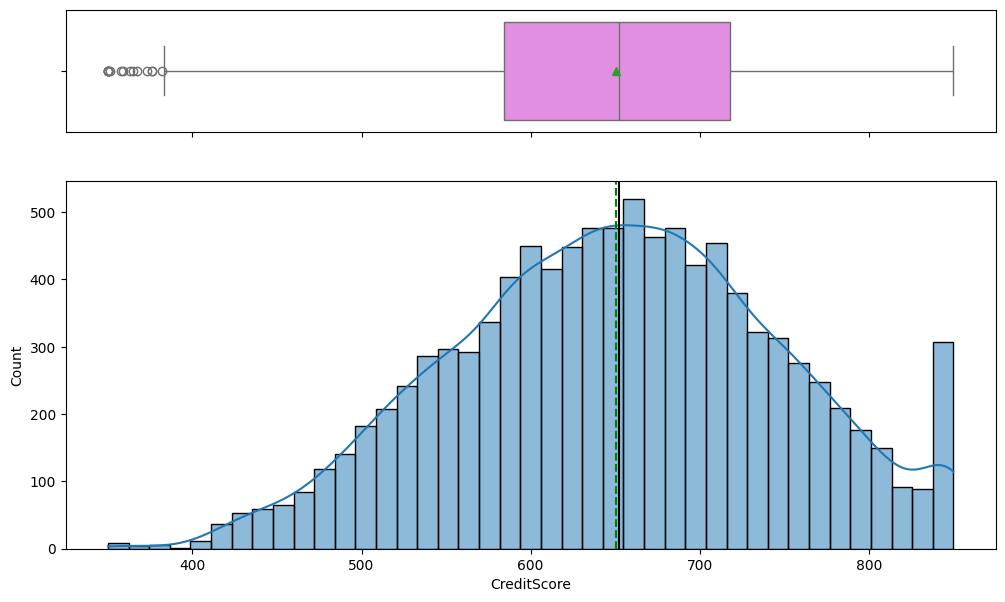

In [160]:
histogram_boxplot(df, "CreditScore", kde=True)

##### Observations
* Distribution looks normal with two exceptions.
  * Very slight left skew
  * There is a spike at a credit score of 850 which should be looked into.
* 50% of customers have a credit score over 650

#### Geography

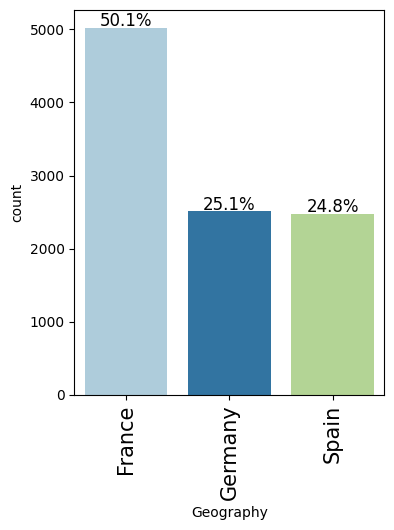

In [161]:
labeled_barplot(df,"Geography", perc=True)

##### Observations
* 50% of customers are from France.
* 50% of customers are from Germany and Spain.

#### Gender

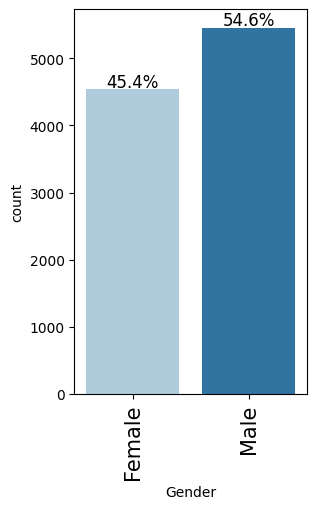

In [162]:
labeled_barplot(df,"Gender", perc=True)

##### Observations
* There are 9.2% more male customers than there are women customers.

#### Age

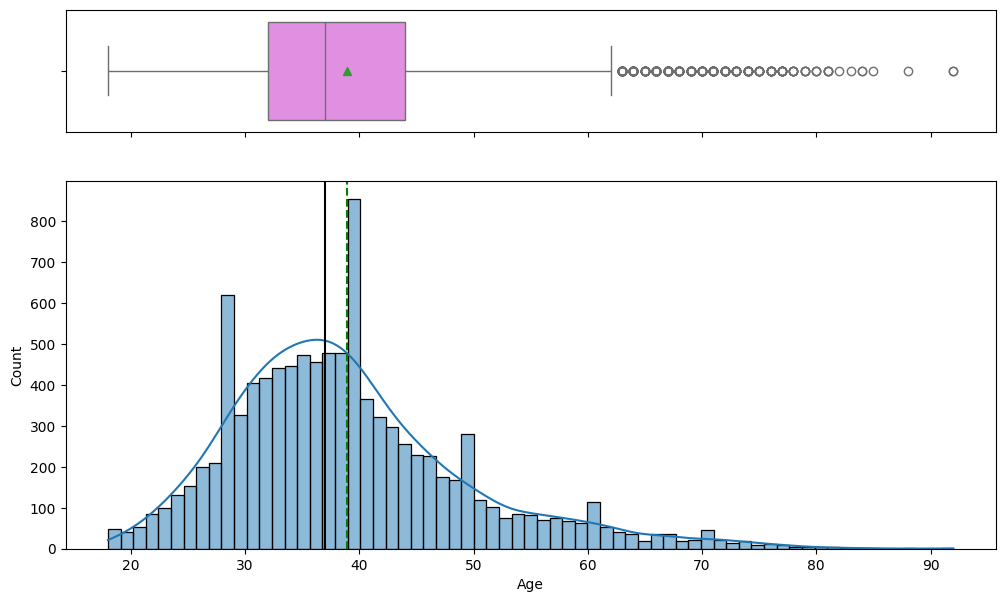

In [163]:
histogram_boxplot(df, "Age", kde=True)

##### Observations
* Data is right-skewed.
* The age group of 39 is almost double all other groups with the exception of 28 year-olds
* 50% of customers are over 38 and 50% are between 18 and 38

#### Tenure

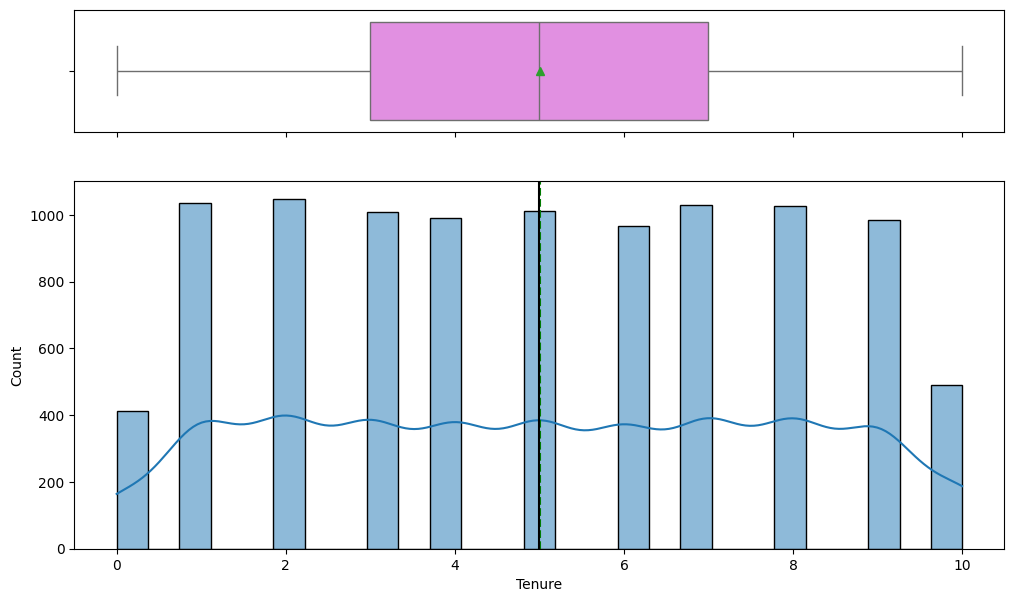

In [164]:
histogram_boxplot(df, "Tenure", kde=True)

##### Observations
* Roughly 1,000 customers are in each tenure group from 1 year to 9 years creating a flat distribution.
* 0 years and 10 years have 400 and 500 customers respectively.


#### Balance

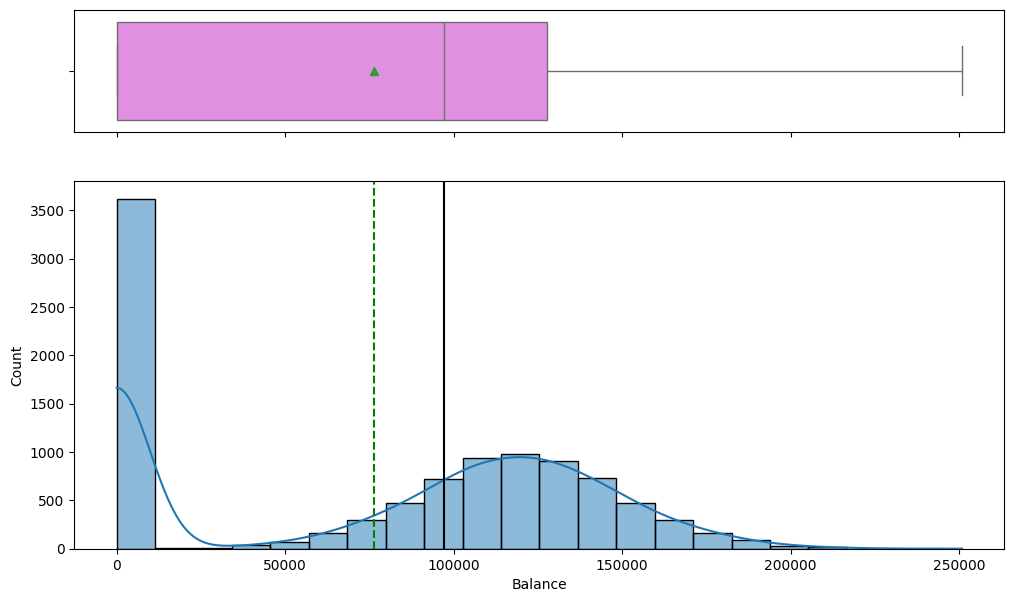

In [165]:
histogram_boxplot(df, "Balance", kde=True)

##### Observations
* Balance has a high negative skew because 3,500 customers have a balance of zero dollars.
* 75% of customers have a balance below $125,000

#### NumOfProducts

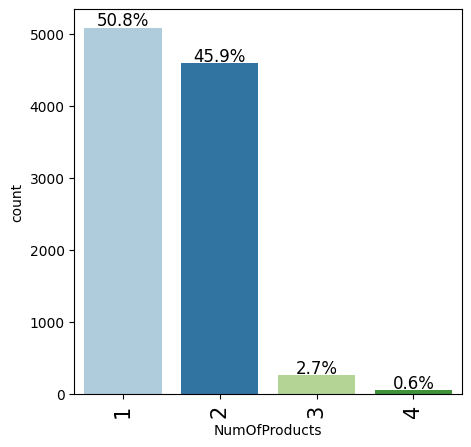

In [166]:
labeled_barplot(df,"NumOfProducts", perc=True)

##### Observations
* The majority of customers only have one or two products.

#### HasCrCard

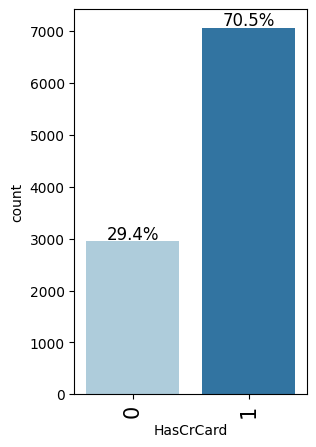

In [167]:
labeled_barplot(df,"HasCrCard", perc=True)

##### Observations
* Over 70% of customers have a credit card with the bank.

#### IsActiveMember

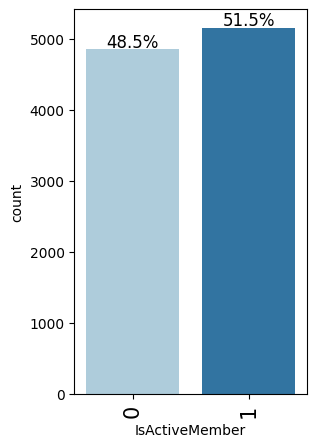

In [168]:
labeled_barplot(df,"IsActiveMember", perc=True)

##### Observations
* Only 51.5% of customers regularly use bank services.

#### EstimatedSalary

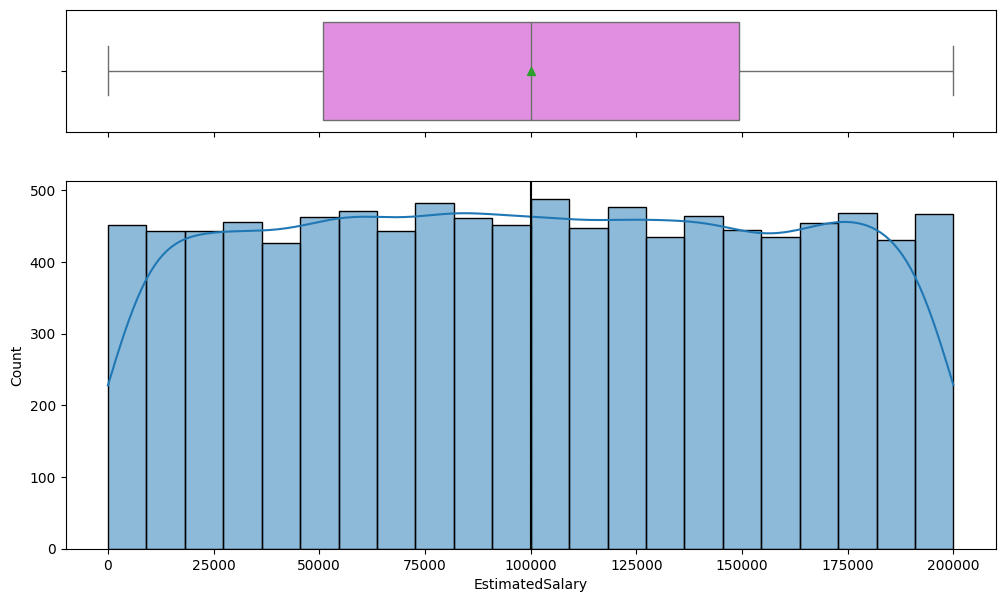

In [169]:
histogram_boxplot(df, "EstimatedSalary", kde=True)

##### Observations
* Flat distribution with no skew.

#### Exited

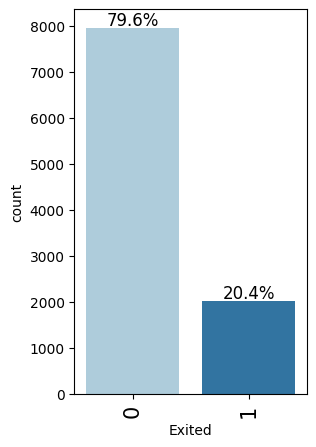

In [170]:
labeled_barplot(df,"Exited", perc=True)

##### Observations
* 20.4.% of customers in this sample have exited the bank.

### Bivariate Analysis

#### Heat Map Correlation

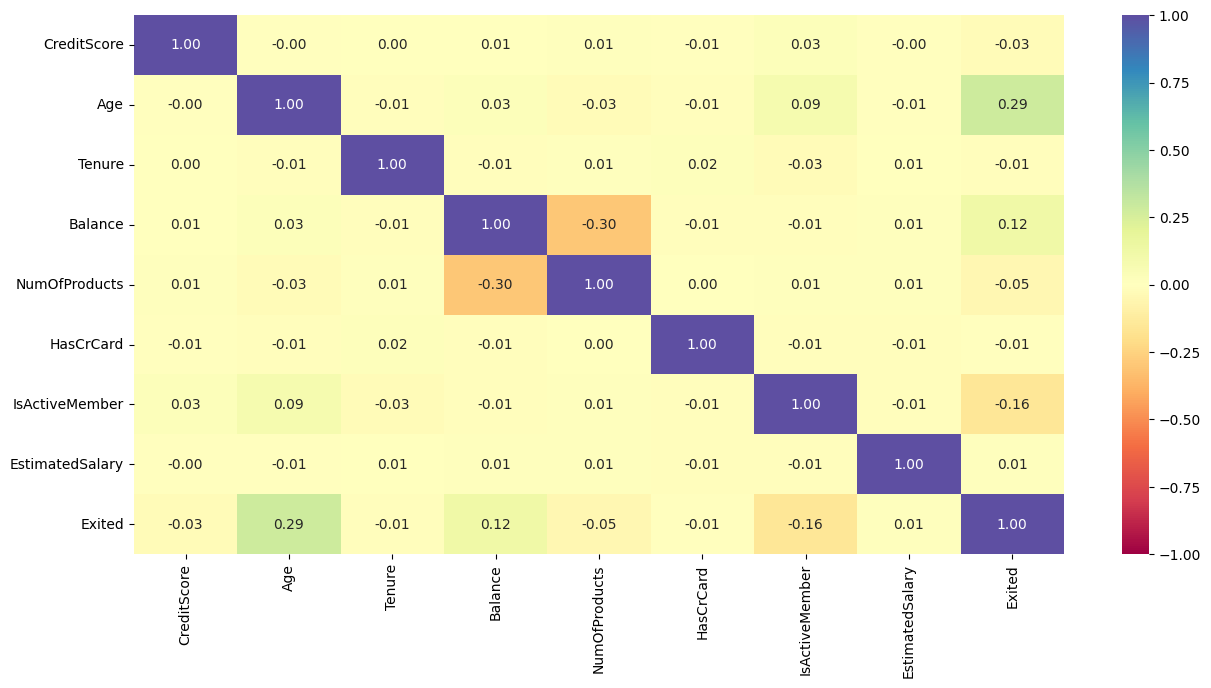

In [171]:
plt.figure(figsize=(15, 7))
sns.heatmap(df.corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral")
plt.show()

##### Observations
* There is a weak positive correlation between Age and Exited.
  * As age goes up the exit rate tends to go up.
* There is a weak negative correlation between NumOfProducts and Balance.
  * As number of products increase the balance decreases.

#### CreditScore vs. Exited

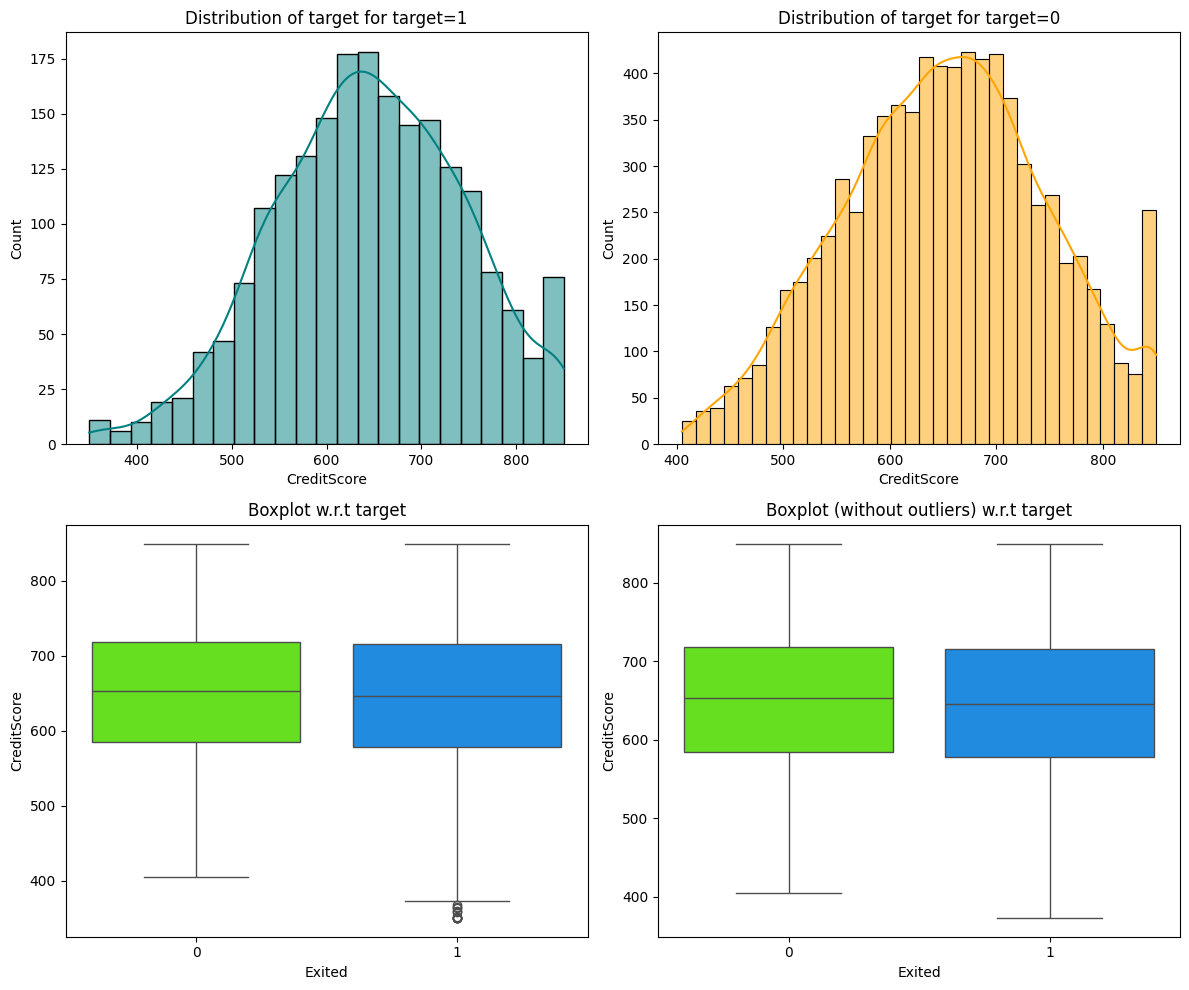

In [172]:
distribution_plot_wrt_target(df,'CreditScore', 'Exited')

##### Observations
* Distributions are essentially the same with a very slight left skew.
* Customers who have exited have more individuals with a credit score under 400.

#### Geography vs. Exited

Exited        0     1    All
Geography                   
All        7963  2037  10000
Germany    1695   814   2509
France     4204   810   5014
Spain      2064   413   2477
------------------------------------------------------------------------------------------------------------------------


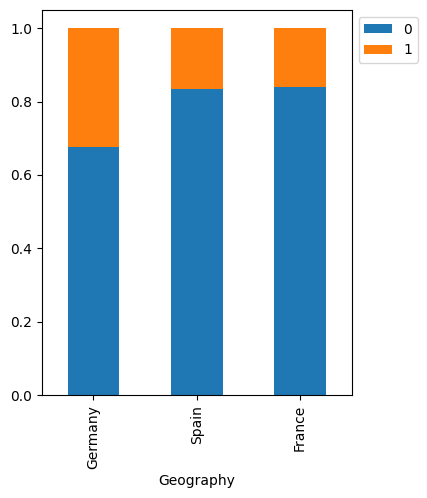

In [173]:
stacked_barplot(df, "Geography", "Exited")

##### Observations
* The German market has the largest percentage of customers whom exit the bank.
  * The German market has roughly a 65% retention rate compared with 80% for Spain and France.

#### Gender vs. Exited

Exited     0     1    All
Gender                   
All     7963  2037  10000
Female  3404  1139   4543
Male    4559   898   5457
------------------------------------------------------------------------------------------------------------------------


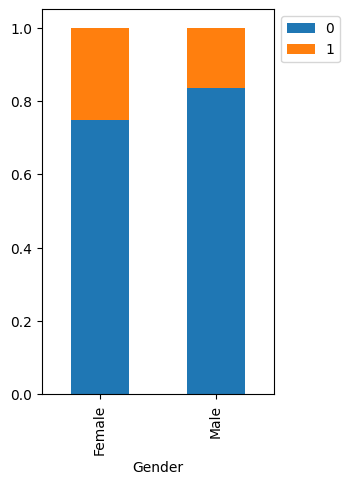

In [174]:
stacked_barplot(df, "Gender", "Exited")

##### Observations
* Females tend to exit the bank as customers a little more than males.
  * Females customers are less of a percentage than males so may be something which is turning female customers off to the bank.

#### Age vs. Exited

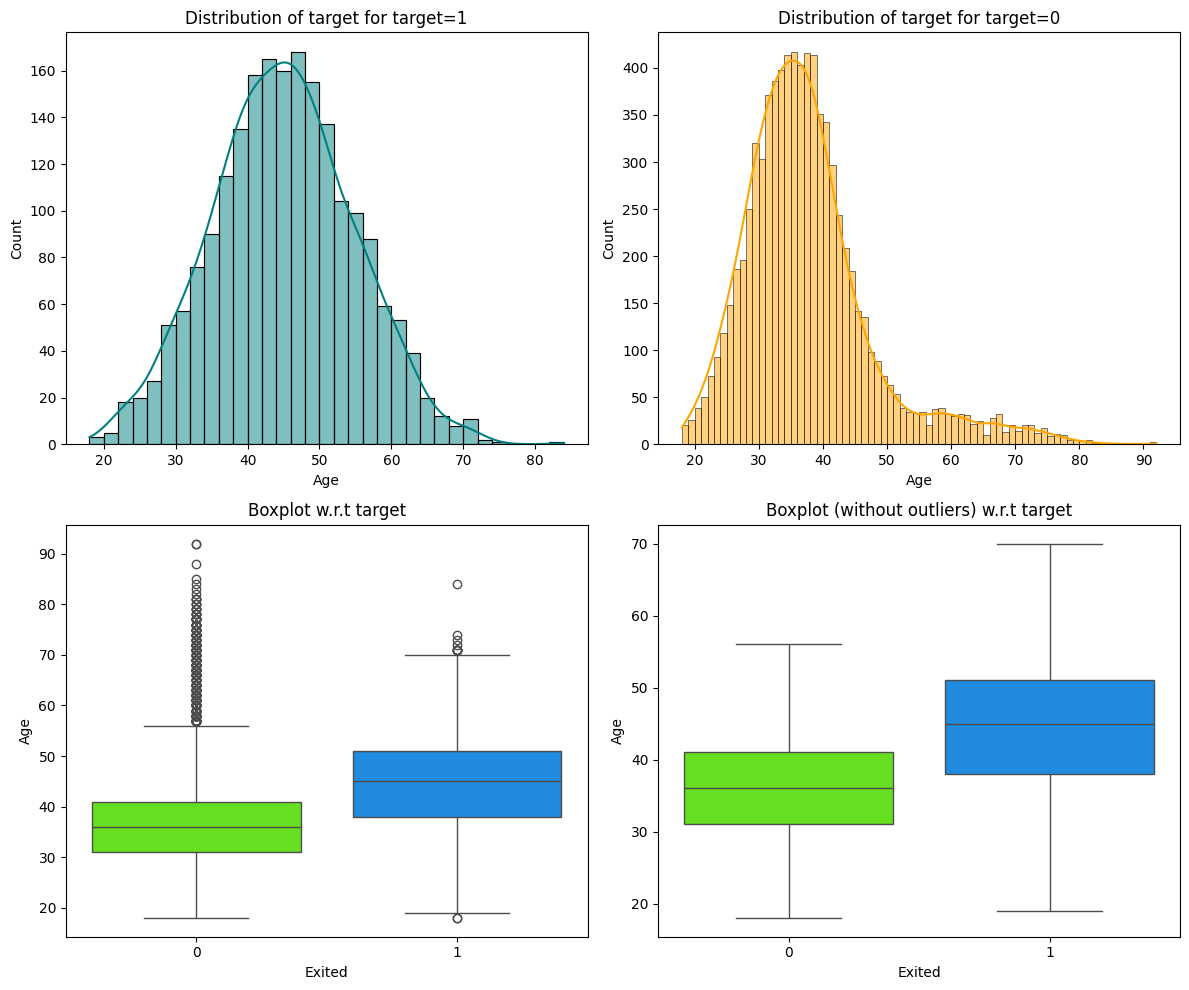

In [175]:
distribution_plot_wrt_target(df,'Age', 'Exited')

##### Observations
* Customers tend to exit the bank most between the ages of 40 and 50.
  * This might show that the bank should reach out more to customers between this age.
* Distribution of customers who have stayed with the bank is right or negative skewed.
* Distribution of customers who have exited the bank is less skewed to the right.


#### Tenure vs. Exited

Exited     0     1    All
Tenure                   
All     7963  2037  10000
1        803   232   1035
3        796   213   1009
9        771   213    984
5        803   209   1012
4        786   203    989
2        847   201   1048
8        828   197   1025
6        771   196    967
7        851   177   1028
10       389   101    490
0        318    95    413
------------------------------------------------------------------------------------------------------------------------


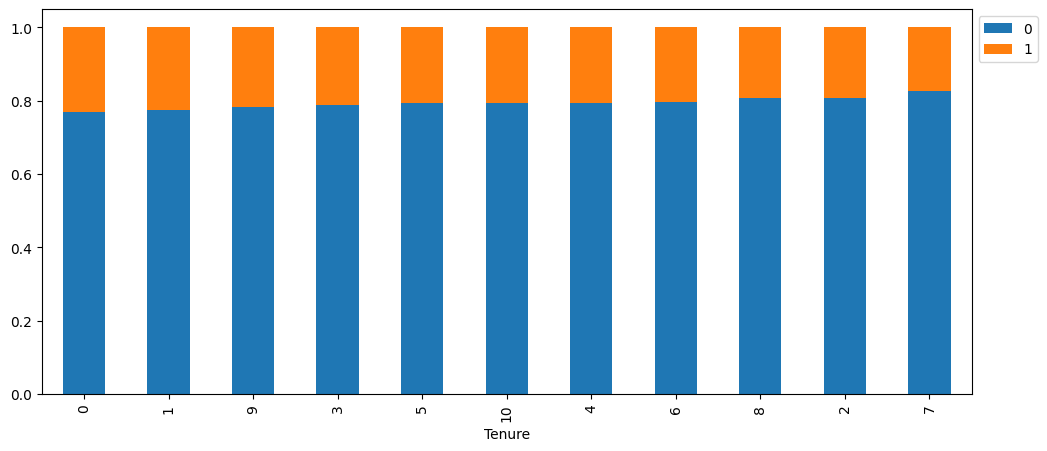

In [176]:
stacked_barplot(df, "Tenure", "Exited")

##### Observations
* This is a relatively uniform distribution where a little more than 20% of customers exit based on their tenure.

#### Balance vs. Exited

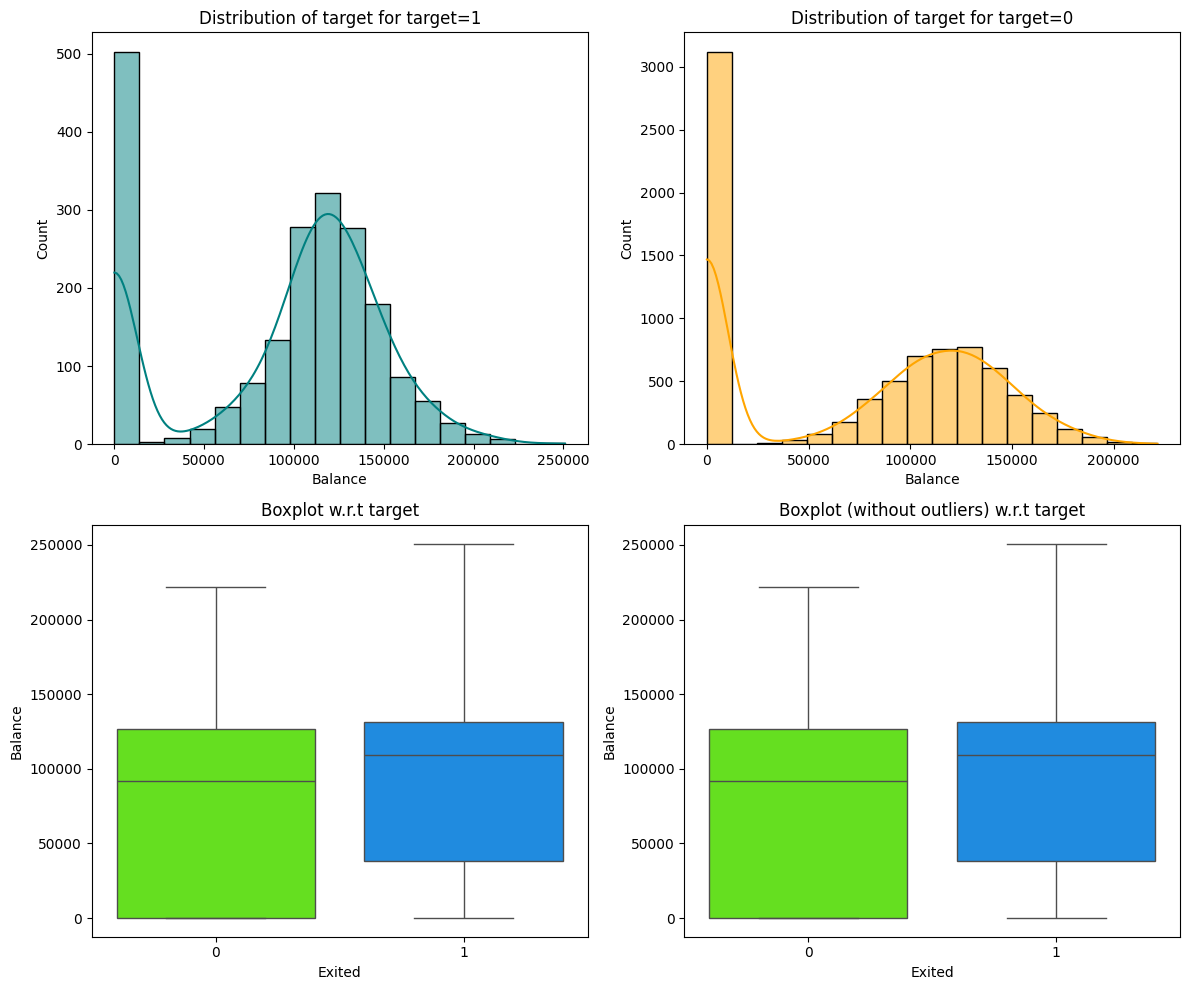

In [177]:
distribution_plot_wrt_target(df,'Balance', 'Exited')

##### Observations
* Bimodal distribution with one mode being an account balance of zero.
  * Distribution between customers who have left and customers who have stayed is roughly the same.
* 50% of customers who have exited have an account balance over $100,000.


#### NumOfProducts vs. Exited

Exited            0     1    All
NumOfProducts                   
All            7963  2037  10000
1              3675  1409   5084
2              4242   348   4590
3                46   220    266
4                 0    60     60
------------------------------------------------------------------------------------------------------------------------


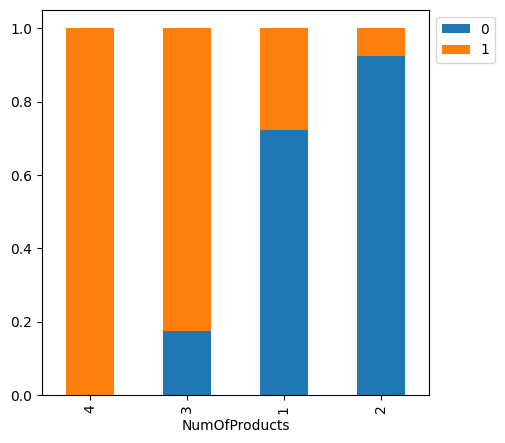

In [178]:
stacked_barplot(df, "NumOfProducts", "Exited")

##### Observations
* Every customer who has had over 3 products have left the bank.
  * What is it about these products which is turing customers off to the bank? Is it because more products are complicating their experience with the bank?
* Over 80% of customers who have had over 2 products have left the bank.
* Customers with two products have the lowest attrition rate.

#### HasCrCard vs. Exited

Exited        0     1    All
HasCrCard                   
All        7963  2037  10000
1          5631  1424   7055
0          2332   613   2945
------------------------------------------------------------------------------------------------------------------------


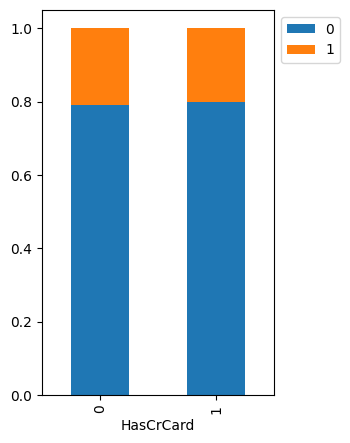

In [179]:
stacked_barplot(df, "HasCrCard", "Exited")

##### Observations
* Whether you have or don't have a bank credit card your attrition rate is about 20%.

#### IsActiveMember vs. Exited

Exited             0     1    All
IsActiveMember                   
All             7963  2037  10000
0               3547  1302   4849
1               4416   735   5151
------------------------------------------------------------------------------------------------------------------------


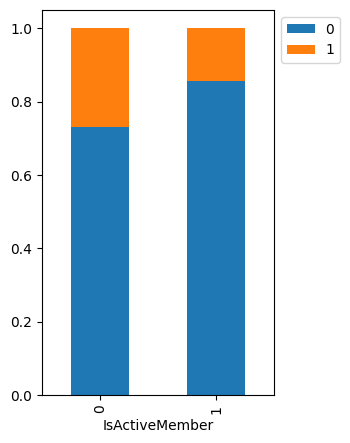

In [180]:
stacked_barplot(df, "IsActiveMember", "Exited")

##### Observations
* If a member is inactive, which means isn't currently using the bank's services. The exit rate is about 25%.
* If a member is active that exit rate is about 15%.
* Inactive members exit the bank more than active members.

#### EstimatedSalary vs. Exited

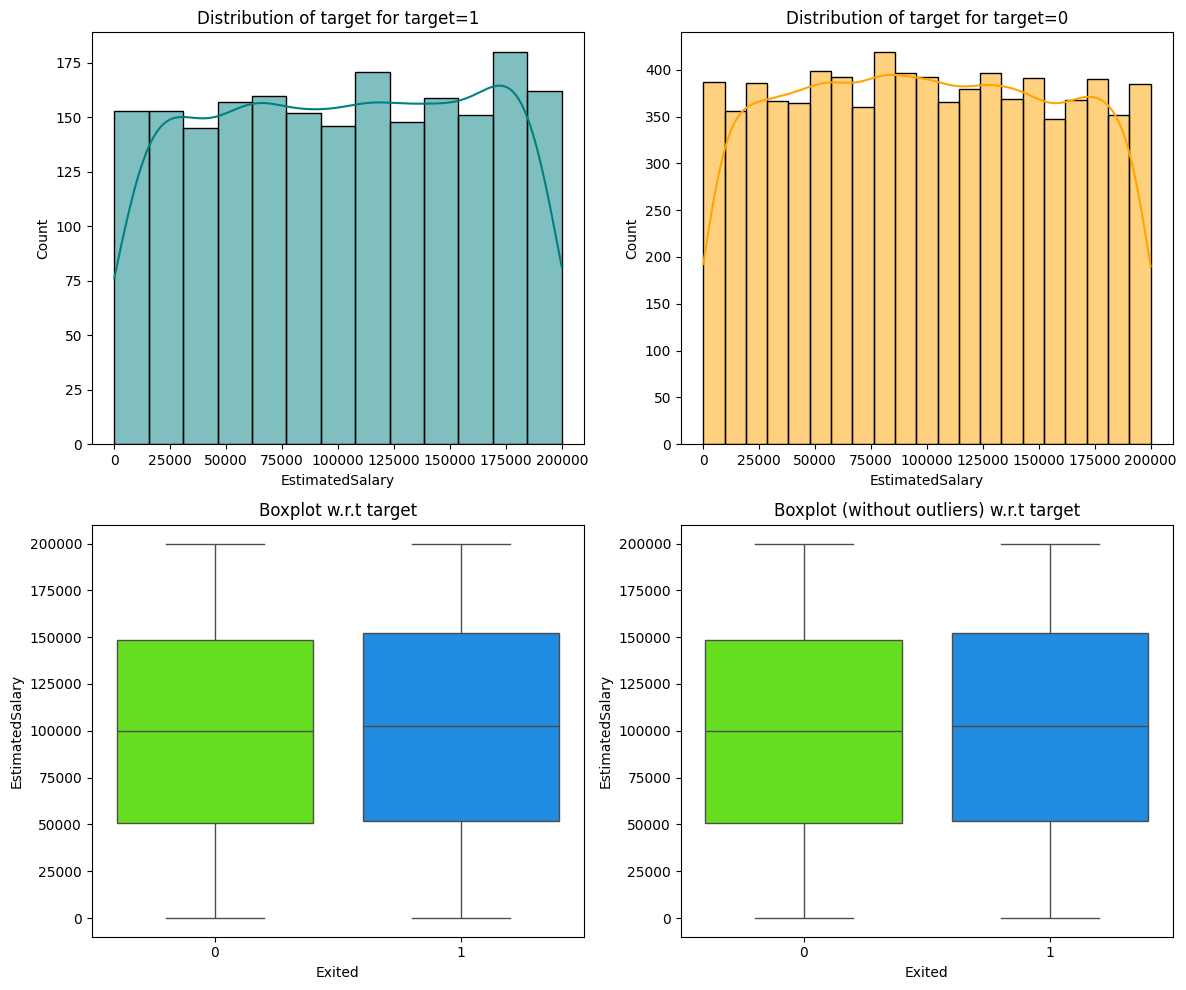

In [181]:
#stacked_barplot(df, "EstimatedSalary", "Exited")
distribution_plot_wrt_target(df,'EstimatedSalary', 'Exited')

##### Observations
* Distribution is uniform among different salaries for customers who exited and customers who did not exit.

## Data Preprocessing

### Train-validation-test Split

In [182]:
# Drop the dependent variable and create set X.
X = df.drop(['Exited'], axis=1);

# Take the independent variable anc create set y.
y = df['Exited'];

# Split the data into train and then a set we will split into test and validation.
X_train, X_large, y_train, y_large = train_test_split(X, y, test_size = .20, random_state = 42,stratify=y,shuffle = True);

# Split the larget set into test and validation
X_test, X_val, y_test, y_val = train_test_split(X_large, y_large, test_size = .50, random_state = 42,stratify=y_large, shuffle = True);

# Data should be split 80% training, 10% validation and 10% testing
print(X_train.shape, X_val.shape, X_test.shape);
print(y_train.shape, y_val.shape, y_test.shape);

(8000, 10) (1000, 10) (1000, 10)
(8000,) (1000,) (1000,)


### Dummy Variable Creation

In [183]:
X_train = pd.get_dummies(X_train, columns=["Geography","Gender"],drop_first=True);
X_test = pd.get_dummies(X_test, columns=["Geography","Gender"],drop_first=True);
X_val = pd.get_dummies(X_val, columns=["Geography","Gender"],drop_first=True);

print(X_train.shape, X_val.shape, X_test.shape);
print(y_train.shape, y_val.shape, y_test.shape);

(8000, 11) (1000, 11) (1000, 11)
(8000,) (1000,) (1000,)


### Data Normalization

In [184]:
cols_list = ["CreditScore","Age","Tenure","Balance","EstimatedSalary"]

# Use ScikitLearn standard scaler to distribute data on the same scale.
sc = StandardScaler()

X_train[cols_list] = sc.fit_transform(X_train[cols_list]);
X_val[cols_list] = sc.transform(X_val[cols_list]);
X_test[cols_list] = sc.transform(X_test[cols_list]);

## Model Building

### Model Evaluation Criterion

* Exited value of 0 means the customer stayed at the bank.
* Exited value of 1 means the customer left the bank.

<br>The confustion matrix looks like the following:

||Actual Positive|Actual Negative|
|-|-|-|
|Predicted True|Predicted Leave and Left|**Predicted Leave and Stayed**|
|Predicted False|**Predicted Stay and Left**|Predicted Stay and Stayed|

<br>**Type I** error is a customer which we predict to leave, but they stayed. Even though we were wrong this isn't as bad because the customer remained with the bank.

**Type II error** is a customer which we predict to stay, but they leave. This will impact the business as we want to minimize churn.

<br>**Conclusion**

Since we are focused on the customers who left and we want to prevent customers who will leave in the future **Precision** should be the main metric we try to optimize.

Precision is True Positives divided by All Actual Positives (True Positive + False Positive).

In [185]:
# Add a data frame which will track recall through our model evaluation.
train_metric_df = pd.DataFrame(columns=["recall"])
valid_metric_df = pd.DataFrame(columns=["recall"])

### Model 0 - Neural Network with SGD Optimizer

* Neural Network
  * Sequential
  * Input Layer: 64 Nodes with Relu Activation
  * Hidden Layer 1: 32 Nodes with Relu Activation
  * Output Layer 2: 1 Node with Sigmoid Activation
* Optimizer
  * Stochastic Gradient Descent
  * Metric tracked: Recall
* Loss Function
  * BinaryCrossEntropy
* Training
  * Batch Size: 64
  * Epochs: 100


In [186]:
# Clear the memory.
backend.clear_session()
# Make sure the seed is the same for all random functions
np.random.seed(2)
random.seed(2)
tf.random.set_seed(2)

In [187]:
#Initializing the neural network
model_0 = Sequential()
# Adding the input layer with 64 neurons and relu as activation function
model_0.add(Dense(64, activation='relu', input_dim = X_train.shape[1]))
# Adding 32 neuron to the hidden layer with relu activation function.
model_0.add(Dense(32, activation='relu'))
# Since this is classification, we are using one output neuron and the Sigmoid activation function.
model_0.add(Dense(1, activation = 'sigmoid'))

In [188]:
#Schocastic Gradient Descent as the optimizer with a 0.001 learning rate.
optimizer = tf.keras.optimizers.SGD(0.001)

# We will be using recall to evaluate our model as we want to reduce the number of False Positives.
# That is customers we say are going to not leave the bank, but end up leaving.

metric = keras.metrics.Recall()
# metric = 'accuracy'
#metric = keras.metrics.Precision()
# metric = keras.metrics.F1Score()

# Use BinaryCrossEntropy as the loss function since this is a binary function.
losses = tf.keras.losses.BinaryCrossentropy()

In [189]:
# Compile the model
model_0.compile(loss=losses,optimizer=optimizer,metrics=metric)

In [190]:
model_0.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                768       
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2881 (11.25 KB)
Trainable params: 2881 (11.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [191]:
# Fit the neural network

history_0 = model_0.fit(
    X_train, y_train,
    batch_size=64,
    validation_data=(X_val,y_val),
    epochs=100,
    verbose=1
)

Epoch 1/100
125/125 [==============================] - 1s 4ms/step - loss: 0.6265 - recall: 0.1049 - val_loss: 0.5992 - val_recall: 0.0394
Epoch 2/100
125/125 [==============================] - 0s 2ms/step - loss: 0.5846 - recall: 0.0086 - val_loss: 0.5657 - val_recall: 0.0099
Epoch 3/100
125/125 [==============================] - 0s 2ms/step - loss: 0.5569 - recall: 6.1350e-04 - val_loss: 0.5433 - val_recall: 0.0000e+00
Epoch 4/100
125/125 [==============================] - 0s 2ms/step - loss: 0.5382 - recall: 6.1350e-04 - val_loss: 0.5279 - val_recall: 0.0000e+00
Epoch 5/100
125/125 [==============================] - 0s 2ms/step - loss: 0.5252 - recall: 0.0000e+00 - val_loss: 0.5171 - val_recall: 0.0000e+00
Epoch 6/100
125/125 [==============================] - 0s 2ms/step - loss: 0.5161 - recall: 0.0000e+00 - val_loss: 0.5094 - val_recall: 0.0000e+00
Epoch 7/100
125/125 [==============================] - 0s 2ms/step - loss: 0.5093 - recall: 0.0000e+00 - val_loss: 0.5035 - val_recall

#### Loss

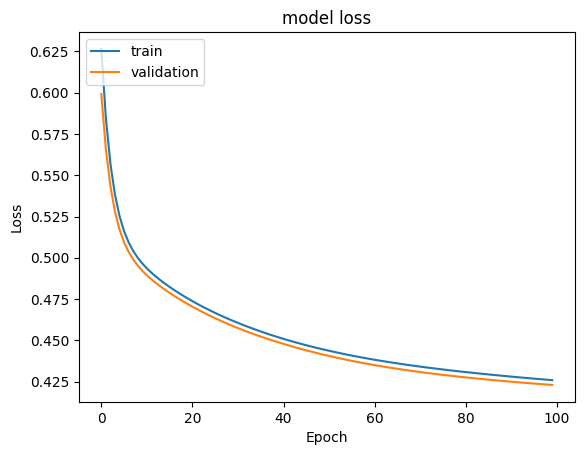

In [192]:
#Train Loss vs Validation Loss
plt.plot(history_0.history['loss'])
plt.plot(history_0.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

##### Observations
* The model is learning, however the loss is still very high.

#### Recall

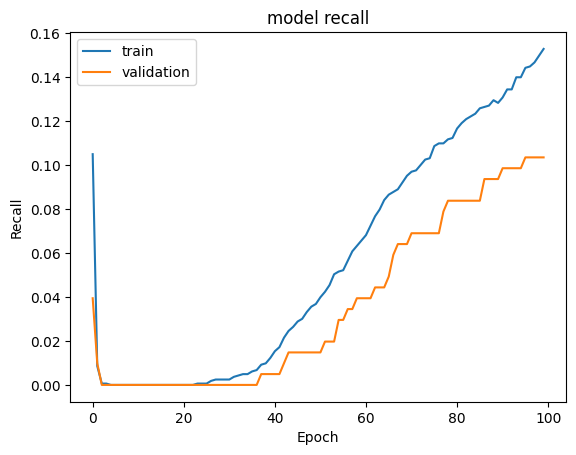

In [193]:
#Train recall vs Validation recall
plt.plot(history_0.history['recall'])
plt.plot(history_0.history['val_recall'])
plt.title('model recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

##### Observations
* Learning doesn't start until Epoch 20 and the data sets diverge immediately.
* The Recall is very poor at 16% so we will try some ways to improve the accuracy of the model.

In [194]:
# Using .5 as the threshold on training
y_train_pred = model_0.predict(X_train)
y_train_pred = (y_train_pred > 0.5)
y_train_pred

250/250 [==============================] - 0s 1ms/step


array([[False],
       [False],
       [False],
       ...,
       [False],
       [False],
       [False]])

In [195]:
# Using .5 as the threshold on validation
y_val_pred = model_0.predict(X_val)
y_val_pred = (y_val_pred > 0.5)
y_val_pred

32/32 [==============================] - 0s 1ms/step


array([[ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [

In [196]:
model_name = "Model 0 - Neural Network with Schocastic Gradient Descent"

train_metric_df.loc[model_name] = recall_score(y_train, y_train_pred)
valid_metric_df.loc[model_name] = recall_score(y_val, y_val_pred)

#### Classification Report

In [197]:
#Classification report
cr = classification_report(y_train, y_train_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.82      0.98      0.89      6370
           1       0.64      0.15      0.24      1630

    accuracy                           0.81      8000
   macro avg       0.73      0.56      0.57      8000
weighted avg       0.78      0.81      0.76      8000



In [198]:
#classification report
cr=classification_report(y_val, y_val_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.81      0.98      0.89       797
           1       0.60      0.10      0.18       203

    accuracy                           0.80      1000
   macro avg       0.71      0.54      0.53      1000
weighted avg       0.77      0.80      0.74      1000



##### Observations
* Out of all the customers which which left the bank the model was only correct 15% of the time on training and 10% of the time on validation.
* F1 score of 24% for training and 18% for validation shows that the model does a poor job in predicting when a customer will leave the bank.

#### Confusion matrix

In [199]:
# Confusion matrix returned an error. 'Series' object has no attribute 'predict'
# make_confusion_matrix(y_train, y_train_pred)
# make_confusion_matrix(y_val,y_val_pred)

### Model 1 - Neural Network with Adam Optimizer

* Neural Network
  * Sequential
  * Input Layer: 64 Nodes with Relu Activation
  * Hidden Layer 1: 32 Nodes with Relu Activation
  * Output Layer 2: 1 Node with Sigmoid Activation
* Optimizer
  * **Adam**
  * Metric tracked: Recall
* Loss Function
  * BinaryCrossEntropy
* Training
  * Batch Size: 64
  * Epochs: 100


In [200]:
# Clear the memory.
backend.clear_session()
# Make sure the seed is the same for all random functions
np.random.seed(2)
random.seed(2)
tf.random.set_seed(2)

In [201]:
#Initializing the neural network
model_1 = Sequential()
# Adding the input layer with 64 neurons and relu as activation function
model_1.add(Dense(64, activation='relu', input_dim = X_train.shape[1]))
# Adding 32 neuron to the hidden layer with relu activation function.
model_1.add(Dense(32, activation='relu'))
# Since this is classification, we are using one output neuron and the Sigmoid activation function.
model_1.add(Dense(1, activation = 'sigmoid'))

In [202]:
# Adam as the optimizer with a 0.001 learning rate.
optimizer = tf.keras.optimizers.Adam(0.001)

# We will be using recall to evaluate our model as we want to reduce the number of False Positives.
# That is customers we say are going to not leave the bank, but end up leaving.
metric = keras.metrics.Recall()
# metric = 'accuracy'
#metric = keras.metrics.Precision()
# metric = keras.metrics.F1Score()

# Use BinaryCrossEntropy as the loss function since this is a binary function.
losses = tf.keras.losses.BinaryCrossentropy()

In [203]:
# Compile the model
model_1.compile(loss=losses,optimizer=optimizer,metrics=[metric])

In [204]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                768       
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2881 (11.25 KB)
Trainable params: 2881 (11.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [205]:
#Fitting the ANN
history_1 = model_1.fit(
    X_train,y_train,
    batch_size=64, ## Complete the code to specify the batch size to use
    validation_data=(X_val,y_val),
    epochs=100, ## Complete the code to specify the number of epochs
    verbose=1
)

Epoch 1/100
125/125 [==============================] - 1s 4ms/step - loss: 0.4633 - recall: 0.0767 - val_loss: 0.4219 - val_recall: 0.1823
Epoch 2/100
125/125 [==============================] - 0s 3ms/step - loss: 0.4169 - recall: 0.2411 - val_loss: 0.4109 - val_recall: 0.1724
Epoch 3/100
125/125 [==============================] - 0s 4ms/step - loss: 0.4046 - recall: 0.2914 - val_loss: 0.4030 - val_recall: 0.3054
Epoch 4/100
125/125 [==============================] - 0s 3ms/step - loss: 0.3935 - recall: 0.3294 - val_loss: 0.3958 - val_recall: 0.3251
Epoch 5/100
125/125 [==============================] - 0s 3ms/step - loss: 0.3837 - recall: 0.3571 - val_loss: 0.3854 - val_recall: 0.3005
Epoch 6/100
125/125 [==============================] - 0s 4ms/step - loss: 0.3762 - recall: 0.3859 - val_loss: 0.3798 - val_recall: 0.3300
Epoch 7/100
125/125 [==============================] - 0s 4ms/step - loss: 0.3676 - recall: 0.3914 - val_loss: 0.3785 - val_recall: 0.4089
Epoch 8/100
125/125 [======

#### Loss

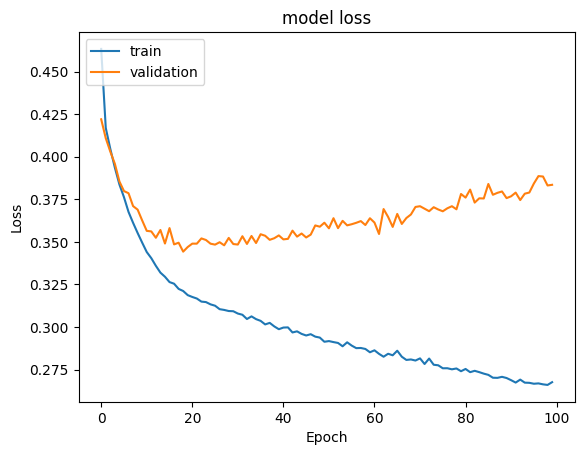

In [206]:
#Train Loss vs Validation Loss
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

##### Observations
* The model fails on the validation set to generalize.
* Loss is still high, but better.

#### Recall

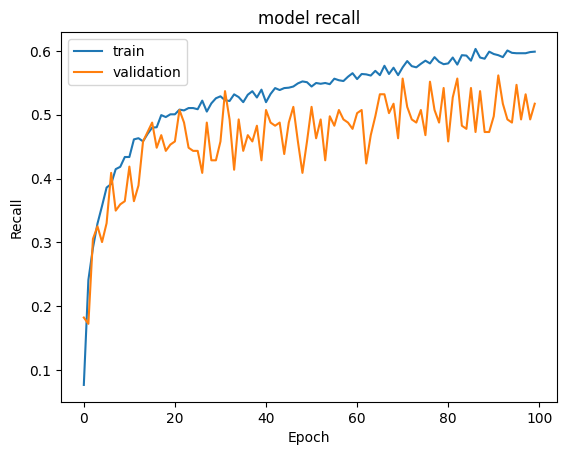

In [207]:
#Train recall vs Validation recall
plt.plot(history_1.history['recall'])
plt.plot(history_1.history['val_recall'])
plt.title('model recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

##### Observations
* Recall is a lot better at around 60%, but the validation set fluctuates between 40% and 50% recall.


In [208]:
#Using 0.5 as the threshold on training
y_train_pred=model_1.predict(X_train)
y_train_pred = (y_train_pred > 0.5)
y_train_pred

250/250 [==============================] - 0s 1ms/step


array([[ True],
       [False],
       [False],
       ...,
       [False],
       [False],
       [False]])

In [209]:
#Using .5 as the threshold on validation
y_val_pred=model_1.predict(X_val)
y_val_pred = (y_val_pred > 0.5)
y_val_pred

32/32 [==============================] - 0s 1ms/step


array([[False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [

In [210]:
model_name = "Model 1 - Neural Network with Adam Optimizer"

train_metric_df.loc[model_name] = recall_score(y_train,y_train_pred)
valid_metric_df.loc[model_name] = recall_score(y_val,y_val_pred)

#### Classification Report

In [211]:
#Classification report
cr=classification_report(y_train,y_train_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.90      0.97      0.94      6370
           1       0.83      0.60      0.70      1630

    accuracy                           0.89      8000
   macro avg       0.87      0.78      0.82      8000
weighted avg       0.89      0.89      0.89      8000



In [212]:
#Classification report
cr=classification_report(y_val, y_val_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.88      0.95      0.91       797
           1       0.71      0.52      0.60       203

    accuracy                           0.86      1000
   macro avg       0.80      0.73      0.76      1000
weighted avg       0.85      0.86      0.85      1000



##### Observations
* The model improved to 60% recall on training data and 53% on validataion.
* F1 score also imporved from on training to 69% and 61% on validation.
* Better results than Model 0

#### Confusion Matrix

In [213]:
# Confusion matrix returned an error. 'Series' object has no attribute 'predict'
# make_confusion_matrix(y_train, y_train_pred)
# make_confusion_matrix(y_val,y_val_pred)

### Model 2 - Neural Network with Adam Optimizer and Dropout
* Neural Network
  * Sequential
  * Input Layer: 64 Nodes with Relu Activation
  * **Dropout** with ratio of 0.20
  * Hidden Layer 1: 32 Nodes with Relu Activation
  * Hidden Layer 2: 16 Nodes with Relu Activation
  * **Dropout** with ratio of 0.10
  * Hidden Layer 3: 8 Nodes with Relu Activation
  * Output Layer: 1 Node with Sigmoid Activation
* Optimizer
  * **Adam Optimizer**
  * Metric tracked: Recall
* Loss Function
  * BinaryCrossEntropy
* Training
  * Batch Size: 64
  * Epochs: 100

In [214]:
# Clear the memory.
backend.clear_session()
# Make sure the seed is the same for all random functions
np.random.seed(2)
random.seed(2)
tf.random.set_seed(2)

In [215]:
#Initializing the neural network
model_2 = Sequential()
# Adding the input layer with 64 neurons and relu as activation function
model_2.add(Dense(64, activation='relu', input_dim = X_train.shape[1]))
model_2.add(Dropout(0.2))
# Adding 32 neuron to the hidden layer with relu activation function.
model_2.add(Dense(32, activation='relu'))
model_2.add(Dense(16, activation='relu'))
model_2.add(Dropout(0.1))
model_2.add(Dense(8, activation='relu'))
# Since this is classification, we are using one output neuron and the Sigmoid activation function.
model_2.add(Dense(1, activation = 'sigmoid'))

In [216]:
# Adam as the optimizer with a 0.001 learning rate.
optimizer = tf.keras.optimizers.Adam(0.001)

# We will be using recall to evaluate our model as we want to reduce the number of False Positives.
# That is customers we say are going to not leave the bank, but end up leaving.
metric = keras.metrics.Recall()
# metric = 'accuracy'
#metric = keras.metrics.Precision()
# metric = keras.metrics.F1Score()

# Use BinaryCrossEntropy as the loss function since this is a binary function.
losses = tf.keras.losses.BinaryCrossentropy()

In [217]:
# Compile the model
model_2.compile(loss=losses,optimizer=optimizer,metrics=[metric])

In [218]:
model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                768       
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_3 (Dense)             (None, 8)                 136       
                                                                 
 dense_4 (Dense)             (None, 1)                 9

In [219]:
#Fitting the ANN
history_2 = model_2.fit(
    X_train,y_train,
    batch_size=64, ## Complete the code to specify the batch size to use
    validation_data=(X_val,y_val),
    epochs=100, ## Complete the code to specify the number of epochs
    verbose=1
)

Epoch 1/100
125/125 [==============================] - 2s 4ms/step - loss: 0.5122 - recall: 0.0405 - val_loss: 0.4338 - val_recall: 0.0000e+00
Epoch 2/100
125/125 [==============================] - 0s 3ms/step - loss: 0.4370 - recall: 0.1129 - val_loss: 0.4236 - val_recall: 0.1281
Epoch 3/100
125/125 [==============================] - 0s 3ms/step - loss: 0.4311 - recall: 0.1840 - val_loss: 0.4215 - val_recall: 0.1527
Epoch 4/100
125/125 [==============================] - 0s 3ms/step - loss: 0.4223 - recall: 0.2202 - val_loss: 0.4145 - val_recall: 0.2069
Epoch 5/100
125/125 [==============================] - 0s 3ms/step - loss: 0.4155 - recall: 0.2485 - val_loss: 0.4088 - val_recall: 0.1921
Epoch 6/100
125/125 [==============================] - 0s 3ms/step - loss: 0.4114 - recall: 0.2761 - val_loss: 0.4036 - val_recall: 0.2118
Epoch 7/100
125/125 [==============================] - 0s 3ms/step - loss: 0.4051 - recall: 0.2896 - val_loss: 0.4034 - val_recall: 0.2808
Epoch 8/100
125/125 [==

#### Loss

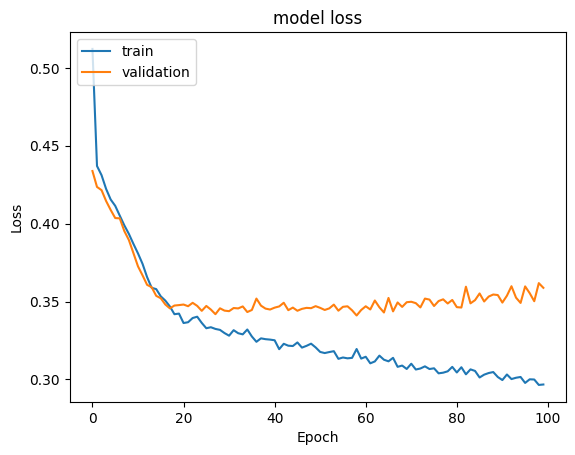

In [220]:
#Train Loss vs Validation Loss
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

##### Observations
* The model fails on the validation set to generalize.
* Loss is more flat in this model as in the last model which had a sharper slope towards 1.

#### Recall

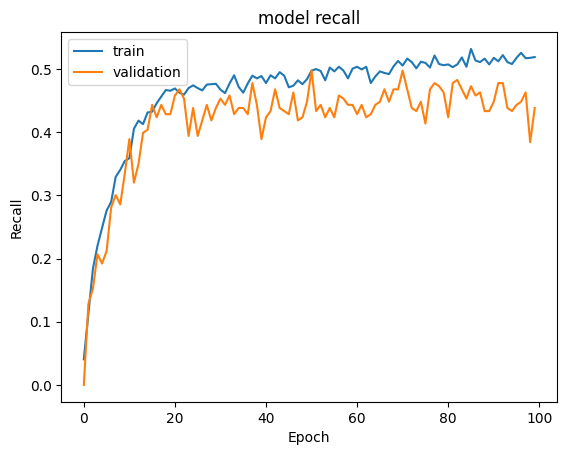

In [221]:
#Train recall vs Validation recall
plt.plot(history_2.history['recall'])
plt.plot(history_2.history['val_recall'])
plt.title('model recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

##### Observations
* Recall is not as good as Model 1. The distance between train and validation might be a little smaller.

In [222]:
#Using 0.5 as the threshold on training
y_train_pred=model_2.predict(X_train)
y_train_pred = (y_train_pred > 0.5)
y_train_pred

250/250 [==============================] - 0s 1ms/step


array([[ True],
       [False],
       [False],
       ...,
       [False],
       [False],
       [False]])

In [223]:
#Using .5 as the threshold on validation
y_val_pred=model_2.predict(X_val)
y_val_pred = (y_val_pred > 0.5)
y_val_pred

32/32 [==============================] - 0s 1ms/step


array([[False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [ True],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [

In [224]:
model_name = "Model 2 - Neural Network with Adam Optimizer and Dropout"

train_metric_df.loc[model_name] = recall_score(y_train,y_train_pred)
valid_metric_df.loc[model_name] = recall_score(y_val,y_val_pred)

#### Classification Report

In [225]:
#Classification report
cr=classification_report(y_train,y_train_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.89      0.98      0.93      6370
           1       0.89      0.53      0.66      1630

    accuracy                           0.89      8000
   macro avg       0.89      0.76      0.80      8000
weighted avg       0.89      0.89      0.88      8000



In [226]:
#Classification report
cr=classification_report(y_val, y_val_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.87      0.96      0.91       797
           1       0.74      0.44      0.55       203

    accuracy                           0.85      1000
   macro avg       0.80      0.70      0.73      1000
weighted avg       0.84      0.85      0.84      1000



##### Observations
* The model regressed to 53% recall on training data and 44% on validataion.
* F1 score also regressed from on training to 66% and 55% on validation.
* Not as good of results as model 1

#### Confusion Matrix

In [227]:
# Confusion matrix returned an error. 'Series' object has no attribute 'predict'
# make_confusion_matrix(y_train, y_train_pred)
# make_confusion_matrix(y_val,y_val_pred)

### Model 3 - Neural Network with Balanced Data (by applying SMOTE) and SGD Optimizer
* **SMOTE** applied to training set.
* Neural Network
  * Sequential
  * Input Layer: 64 Nodes with Relu Activation
  * Hidden Layer 1: 32 Nodes with Relu Activation
  * Hidden Layer 2: 16 Nodes with Relu Activation
  * Output Layer: 1 Node with Sigmoid Activation
* Optimizer
  * **Schocastic Gradient Descent Optimizer**
  * Metric tracked: Recall
* Loss Function
  * BinaryCrossEntropy
* Training
  * Batch Size: 64
  * Epochs: 100

#### Add SMOTE to training set

In [228]:
sm  = SMOTE(random_state=42)
#Complete the code to fit SMOTE on the training data.
X_train_smote, y_train_smote= sm.fit_resample(X_train,y_train)
print('After UpSampling, the shape of train_X: {}'.format(X_train_smote.shape))
print('After UpSampling, the shape of train_y: {} \n'.format(y_train_smote.shape))

After UpSampling, the shape of train_X: (12740, 11)
After UpSampling, the shape of train_y: (12740,) 



In [229]:
backend.clear_session()
#Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(2)
random.seed(2)
tf.random.set_seed(2)

In [230]:
#Initializing the neural network
model_3 = Sequential()
# Adding the input layer with 64 neurons and relu as activation function
model_3.add(Dense(64, activation='relu', input_dim = X_train.shape[1]))
# Adding 32 neuron to the hidden layer with relu activation function.
model_3.add(Dense(32, activation='relu'))
# Adding 16 neuron to the hidden layer with relu activation function.
model_3.add(Dense(16, activation='relu'))
# Since this is classification, we are using one output neuron and the Sigmoid activation function.
model_3.add(Dense(1, activation = 'sigmoid'))

In [231]:
#Schocastic Gradient Descent as the optimizer with a 0.001 learning rate.
optimizer = tf.keras.optimizers.SGD(0.001)

# We will be using recall to evaluate our model as we want to reduce the number of False Positives.
# That is customers we say are going to not leave the bank, but end up leaving.

metric = keras.metrics.Recall()
# metric = 'accuracy'
#metric = keras.metrics.Precision()
# metric = keras.metrics.F1Score()

# Use BinaryCrossEntropy as the loss function since this is a binary function.
losses = tf.keras.losses.BinaryCrossentropy()

In [232]:
# Compile the model
model_3.compile(loss=losses,optimizer=optimizer,metrics=[metric])

In [233]:
model_3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                768       
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 3393 (13.25 KB)
Trainable params: 3393 (13.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [234]:
# Fit the neural network
history_3 = model_3.fit(
    X_train_smote, y_train_smote,
    batch_size=64,
    epochs=100,
    verbose=1,
    validation_data = (X_val,y_val)
)

Epoch 1/100
200/200 [==============================] - 1s 3ms/step - loss: 0.6910 - recall: 0.5546 - val_loss: 0.6918 - val_recall: 0.5271
Epoch 2/100
200/200 [==============================] - 0s 2ms/step - loss: 0.6885 - recall: 0.5796 - val_loss: 0.6895 - val_recall: 0.5419
Epoch 3/100
200/200 [==============================] - 0s 2ms/step - loss: 0.6860 - recall: 0.5961 - val_loss: 0.6873 - val_recall: 0.5567
Epoch 4/100
200/200 [==============================] - 1s 3ms/step - loss: 0.6835 - recall: 0.6152 - val_loss: 0.6849 - val_recall: 0.5714
Epoch 5/100
200/200 [==============================] - 1s 3ms/step - loss: 0.6810 - recall: 0.6297 - val_loss: 0.6822 - val_recall: 0.5616
Epoch 6/100
200/200 [==============================] - 1s 3ms/step - loss: 0.6785 - recall: 0.6438 - val_loss: 0.6800 - val_recall: 0.5764
Epoch 7/100
200/200 [==============================] - 1s 3ms/step - loss: 0.6760 - recall: 0.6512 - val_loss: 0.6775 - val_recall: 0.6010
Epoch 8/100
200/200 [======

#### Loss

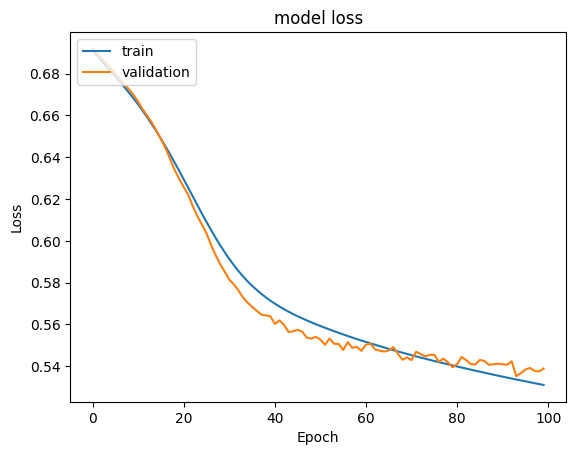

In [235]:
#Train Loss vs Validation Loss
plt.plot(history_3.history['loss'])
plt.plot(history_3.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

##### Observations
* Training and validation data are showing similar trends indicating the model is starting to generalize.
* Model loss is high at .54.

#### Recall

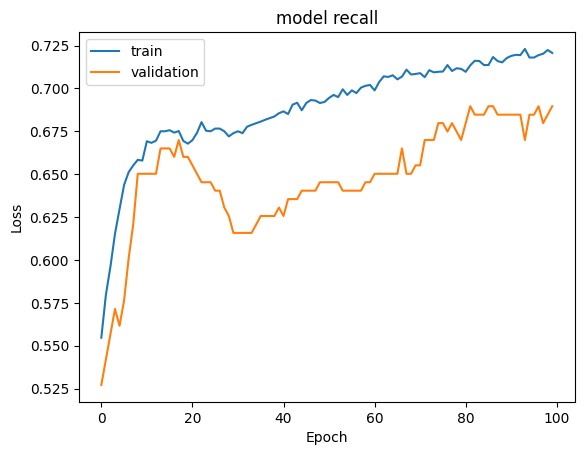

In [236]:
#Train recall vs Validation recall
plt.plot(history_3.history['recall'])
plt.plot(history_3.history['val_recall'])
plt.title('model recall')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

##### Observations
* Model diverges at 20 epoch.
* The recall appears to be the highest, but still doesn't look like the model is generalized.

In [237]:
#Using .5 as the threshold on training
y_train_pred = model_3.predict(X_train_smote)
y_train_pred = (y_train_pred > 0.5)
y_train_pred

399/399 [==============================] - 1s 1ms/step


array([[ True],
       [False],
       [False],
       ...,
       [False],
       [ True],
       [False]])

In [238]:
#Using .5 as the threshold on training
y_val_pred = model_3.predict(X_val)
y_val_pred = (y_val_pred > 0.5)
y_val_pred

32/32 [==============================] - 0s 1ms/step


array([[ True],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [False],
       [ True],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [

In [239]:
model_name = "Model 3 - Neural Network with SMOTE and Schocastic Gradient Descent"

train_metric_df.loc[model_name] = recall_score(y_train_smote,y_train_pred)
valid_metric_df.loc[model_name] = recall_score(y_val,y_val_pred)

#### Classification Report

In [240]:
#Classification report
cr = classification_report(y_train_smote, y_train_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.73      0.74      0.74      6370
           1       0.74      0.72      0.73      6370

    accuracy                           0.73     12740
   macro avg       0.73      0.73      0.73     12740
weighted avg       0.73      0.73      0.73     12740



In [241]:
#classification report
cr=classification_report(y_val, y_val_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.90      0.75      0.82       797
           1       0.41      0.69      0.52       203

    accuracy                           0.74      1000
   macro avg       0.66      0.72      0.67      1000
weighted avg       0.80      0.74      0.76      1000



##### Observations
* Recall is 72% for training and 69% for validation.
* F1 is 73% and 52% respectively. It would be nice to bring these scores together.

#### Confusion Matrix

In [242]:
# Confusion matrix returned an error. 'Series' object has no attribute 'predict'
# make_confusion_matrix(y_train, y_train_pred)
# make_confusion_matrix(y_val,y_val_pred)

### Model 4 - Neural Network with Balanced Data (by applying SMOTE) and Adam Optimizer

* **SMOTE** applied to training set.
* Neural Network
  * Sequential
  * Input Layer: 64 Nodes with Relu Activation
  * Hidden Layer 1: 32 Nodes with Relu Activation
  * Hidden Layer 2: 16 Nodes with Relu Activation
  * Output Layer: 1 Node with Sigmoid Activation
* Optimizer
  * **Adam Optimizer**
  * Metric tracked: Recall
* Loss Function
  * BinaryCrossEntropy
* Training
  * Batch Size: 64
  * Epochs: 100

#### Add SMOTE to training set

In [243]:
sm  = SMOTE(random_state=42)
#Complete the code to fit SMOTE on the training data.
X_train_smote, y_train_smote= sm.fit_resample(X_train,y_train)
print('After UpSampling, the shape of train_X: {}'.format(X_train_smote.shape))
print('After UpSampling, the shape of train_y: {} \n'.format(y_train_smote.shape))

After UpSampling, the shape of train_X: (12740, 11)
After UpSampling, the shape of train_y: (12740,) 



In [244]:
backend.clear_session()
#Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(2)
random.seed(2)
tf.random.set_seed(2)

In [245]:
#Initializing the neural network
model_4 = Sequential()
# Adding the input layer with 64 neurons and relu as activation function
model_4.add(Dense(64, activation='relu', input_dim = X_train.shape[1]))
# Adding 32 neuron to the hidden layer with relu activation function.
model_4.add(Dense(32, activation='relu'))
# Adding 16 neuron to the hidden layer with relu activation function.
model_4.add(Dense(16, activation='relu'))
# Since this is classification, we are using one output neuron and the Sigmoid activation function.
model_4.add(Dense(1, activation = 'sigmoid'))

In [246]:
#Schocastic Gradient Descent as the optimizer with a 0.001 learning rate.
optimizer = tf.keras.optimizers.Adam(0.001)

# We will be using recall to evaluate our model as we want to reduce the number of False Positives.
# That is customers we say are going to not leave the bank, but end up leaving.

metric = keras.metrics.Recall()
# metric = 'accuracy'
#metric = keras.metrics.Precision()
# metric = keras.metrics.F1Score()

# Use BinaryCrossEntropy as the loss function since this is a binary function.
losses = tf.keras.losses.BinaryCrossentropy()

In [247]:
# Compile the model
model_4.compile(loss=losses,optimizer=optimizer,metrics=[metric])

In [248]:
model_4.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                768       
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 3393 (13.25 KB)
Trainable params: 3393 (13.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [249]:
# Fit the neural network
history_4 = model_4.fit(
    X_train_smote, y_train_smote,
    batch_size=64,
    epochs=100,
    verbose=1,
    validation_data = (X_val,y_val)
)

Epoch 1/100
200/200 [==============================] - 2s 4ms/step - loss: 0.5708 - recall: 0.6958 - val_loss: 0.5034 - val_recall: 0.6650
Epoch 2/100
200/200 [==============================] - 1s 3ms/step - loss: 0.5025 - recall: 0.7399 - val_loss: 0.4910 - val_recall: 0.7143
Epoch 3/100
200/200 [==============================] - 1s 3ms/step - loss: 0.4699 - recall: 0.7716 - val_loss: 0.4287 - val_recall: 0.6207
Epoch 4/100
200/200 [==============================] - 1s 4ms/step - loss: 0.4515 - recall: 0.7750 - val_loss: 0.4881 - val_recall: 0.7685
Epoch 5/100
200/200 [==============================] - 1s 4ms/step - loss: 0.4331 - recall: 0.7998 - val_loss: 0.4434 - val_recall: 0.7143
Epoch 6/100
200/200 [==============================] - 1s 4ms/step - loss: 0.4198 - recall: 0.8053 - val_loss: 0.4501 - val_recall: 0.7143
Epoch 7/100
200/200 [==============================] - 1s 4ms/step - loss: 0.4112 - recall: 0.8119 - val_loss: 0.4195 - val_recall: 0.6897
Epoch 8/100
200/200 [======

#### Loss

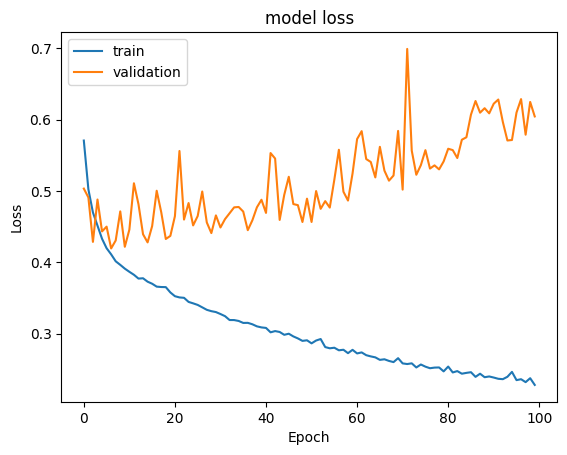

In [250]:
#Train Loss vs Validation Loss
plt.plot(history_4.history['loss'])
plt.plot(history_4.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

##### Observations
* Model loss on training data is the lowest yet, however, validation data loss is very bad showing signs of overfitting.

#### Recall

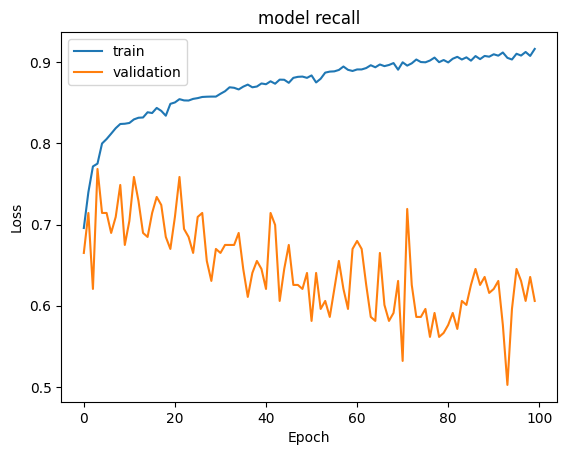

In [251]:
#Train recall vs Validation recall
plt.plot(history_4.history['recall'])
plt.plot(history_4.history['val_recall'])
plt.title('model recall')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

##### Observations
* Model diverges immediately.
* The recall appears to be the highest for training, but is overfit because validation data is diverging immediately.

In [252]:
#Using .5 as the threshold on training
y_train_pred = model_4.predict(X_train_smote)
y_train_pred = (y_train_pred > 0.5)
y_train_pred

399/399 [==============================] - 1s 1ms/step


array([[ True],
       [ True],
       [False],
       ...,
       [ True],
       [ True],
       [ True]])

In [253]:
#Using .5 as the threshold on training
y_val_pred = model_4.predict(X_val)
y_val_pred = (y_val_pred > 0.5)
y_val_pred

32/32 [==============================] - 0s 1ms/step


array([[ True],
       [False],
       [ True],
       [False],
       [ True],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [ True],
       [ True],
       [False],
       [ True],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [

In [254]:
model_name = "Model 4 - Neural Network with SMOTE and Adam"

train_metric_df.loc[model_name] = recall_score(y_train_smote,y_train_pred)
valid_metric_df.loc[model_name] = recall_score(y_val,y_val_pred)

#### Classification Report

In [255]:
#Classification report
cr = classification_report(y_train_smote, y_train_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.90      0.91      0.91      6370
           1       0.91      0.90      0.91      6370

    accuracy                           0.91     12740
   macro avg       0.91      0.91      0.91     12740
weighted avg       0.91      0.91      0.91     12740



In [256]:
#classification report
cr=classification_report(y_val, y_val_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.89      0.85      0.87       797
           1       0.50      0.61      0.55       203

    accuracy                           0.80      1000
   macro avg       0.70      0.73      0.71      1000
weighted avg       0.81      0.80      0.80      1000



##### Observations
* Recall is 90% for training and 58% for validation.
* F1 is 90% and 53% respectively.
* Model overall looks overfit.

#### Confusion Matrix

In [257]:
# Confusion matrix returned an error. 'Series' object has no attribute 'predict'
# make_confusion_matrix(y_train, y_train_pred)
# make_confusion_matrix(y_val,y_val_pred)

### Model 5 - Neural Network with Balanced Data (by applying SMOTE), Adam Optimizer, and Dropout

* **SMOTE** applied to training set.
* Neural Network
  * Sequential
  * Input Layer: 64 Nodes with Relu Activation
  * **Dropout** with rate of .6.
  * Hidden Layer 1: 32 Nodes with Relu Activation
  * **Dropout** with a rate of .6.
  * Hidden Layer 2: 16 Nodes with Relu Activation
  * Output Layer: 1 Node with Sigmoid Activation
* Optimizer
  * **Adam Optimizer**
  * Metric tracked: Recall
* Loss Function
  * BinaryCrossEntropy
* Training
  * Batch Size: 64
  * Epochs: 100

#### Add SMOTE to training set

In [258]:
sm  = SMOTE(random_state=42)
#Complete the code to fit SMOTE on the training data.
X_train_smote, y_train_smote= sm.fit_resample(X_train,y_train)
print('After UpSampling, the shape of train_X: {}'.format(X_train_smote.shape))
print('After UpSampling, the shape of train_y: {} \n'.format(y_train_smote.shape))

After UpSampling, the shape of train_X: (12740, 11)
After UpSampling, the shape of train_y: (12740,) 



In [259]:
backend.clear_session()
#Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(2)
random.seed(2)
tf.random.set_seed(2)

In [260]:
#Initializing the neural network
model_5 = Sequential()
# Adding the input layer with 64 neurons and relu as activation function
model_5.add(Dense(64, activation='relu', input_dim = X_train.shape[1]))
# Adding dropout with rate of .8
model_5.add(Dropout(0.6))
# Adding 32 neuron to the hidden layer with relu activation function.
model_5.add(Dense(32, activation='relu'))
# Adding dropout with rate of .6
model_5.add(Dropout(0.6))
# Adding 16 neuron to the hidden layer with relu activation function.
model_5.add(Dense(16, activation='relu'))
# Since this is classification, we are using one output neuron and the Sigmoid activation function.
model_5.add(Dense(1, activation = 'sigmoid'))

In [261]:
#Schocastic Gradient Descent as the optimizer with a 0.001 learning rate.
optimizer = tf.keras.optimizers.Adam(0.001)

# We will be using recall to evaluate our model as we want to reduce the number of False Positives.
# That is customers we say are going to not leave the bank, but end up leaving.

metric = keras.metrics.Recall()
# metric = 'accuracy'
#metric = keras.metrics.Precision()
# metric = keras.metrics.F1Score()

# Use BinaryCrossEntropy as the loss function since this is a binary function.
losses = tf.keras.losses.BinaryCrossentropy()

In [262]:
# Compile the model
model_5.compile(loss=losses,optimizer=optimizer,metrics=[metric])

In [263]:
model_5.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                768       
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 3393 (13.25 KB)
Trainable params: 3393 (13

In [264]:
# Fit the neural network
history_5 = model_5.fit(
    X_train_smote, y_train_smote,
    batch_size=64,
    epochs=100,
    verbose=1,
    validation_data = (X_val,y_val)
)

Epoch 1/100
200/200 [==============================] - 2s 4ms/step - loss: 0.6655 - recall: 0.5841 - val_loss: 0.5679 - val_recall: 0.6355
Epoch 2/100
200/200 [==============================] - 1s 3ms/step - loss: 0.6073 - recall: 0.6766 - val_loss: 0.5502 - val_recall: 0.6700
Epoch 3/100
200/200 [==============================] - 1s 2ms/step - loss: 0.5873 - recall: 0.7074 - val_loss: 0.5738 - val_recall: 0.7094
Epoch 4/100
200/200 [==============================] - 1s 3ms/step - loss: 0.5754 - recall: 0.7094 - val_loss: 0.5675 - val_recall: 0.6946
Epoch 5/100
200/200 [==============================] - 1s 4ms/step - loss: 0.5635 - recall: 0.7177 - val_loss: 0.5663 - val_recall: 0.6650
Epoch 6/100
200/200 [==============================] - 1s 4ms/step - loss: 0.5562 - recall: 0.7008 - val_loss: 0.5547 - val_recall: 0.6601
Epoch 7/100
200/200 [==============================] - 1s 4ms/step - loss: 0.5467 - recall: 0.7168 - val_loss: 0.5544 - val_recall: 0.6502
Epoch 8/100
200/200 [======

#### Loss

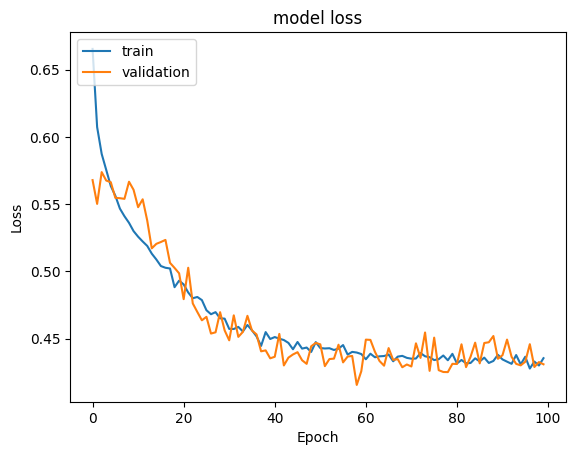

In [265]:
#Train Loss vs Validation Loss
plt.plot(history_5.history['loss'])
plt.plot(history_5.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

##### Observations
* Model loss on training data is the lowest yet, however, validation data loss is very bad showing signs of overfitting.

#### Recall

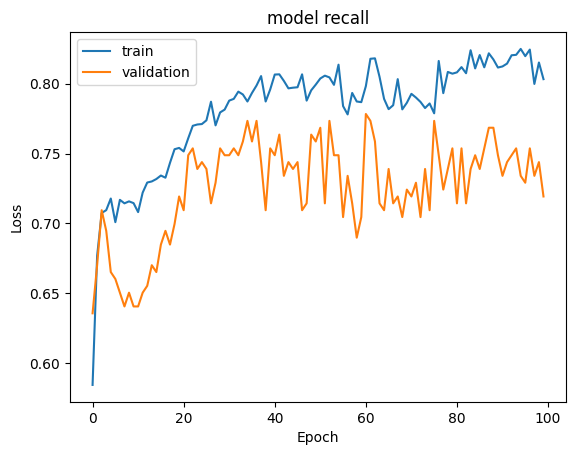

In [266]:
#Train recall vs Validation recall
plt.plot(history_5.history['recall'])
plt.plot(history_5.history['val_recall'])
plt.title('model recall')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

##### Observations
* Model diverges immediately.
* The recall appears to be the highest for training, but is overfit because validation data is diverging immediately.

In [267]:
#Using .5 as the threshold on training
y_train_pred = model_5.predict(X_train_smote)
y_train_pred = (y_train_pred > 0.5)
y_train_pred

399/399 [==============================] - 1s 1ms/step


array([[ True],
       [ True],
       [False],
       ...,
       [ True],
       [ True],
       [ True]])

In [268]:
#Using .5 as the threshold on training
y_val_pred = model_5.predict(X_val)
y_val_pred = (y_val_pred > 0.5)
y_val_pred

32/32 [==============================] - 0s 1ms/step


array([[False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [ True],
       [False],
       [False],
       [ True],
       [ True],
       [False],
       [ True],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [

In [269]:
y_test_pred = model_5.predict(X_test)    ## Complete the code to specify the best model
y_test_pred = (y_test_pred > 0.5)
print(y_test_pred)

32/32 [==============================] - 0s 1ms/step
[[ True]
 [ True]
 [False]
 [False]
 [False]
 [ True]
 [False]
 [False]
 [ True]
 [False]
 [False]
 [False]
 [False]
 [False]
 [ True]
 [False]
 [False]
 [False]
 [False]
 [False]
 [ True]
 [False]
 [False]
 [False]
 [False]
 [False]
 [ True]
 [False]
 [False]
 [ True]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [ True]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [ True]
 [False]
 [ True]
 [False]
 [ True]
 [False]
 [ True]
 [False]
 [ True]
 [False]
 [False]
 [False]
 [False]
 [ True]
 [ True]
 [False]
 [False]
 [False]
 [False]
 [False]
 [ True]
 [ True]
 [False]
 [False]
 [False]
 [False]
 [False]
 [ True]
 [False]
 [ True]
 [False]
 [False]
 [False]
 [False]
 [False]
 [ True]
 [False]
 [False]
 [ True]
 [ True]
 [False]
 [ True]
 [ True]
 [False]
 [False]
 [False]
 [ True]
 [ True]
 [False]
 [False]
 [ True]
 [False]
 [False]
 [ True]
 [ True]
 [False]
 [False]
 [ True]
 [False]
 [ True]
 [

In [270]:
model_name = "Model 5 = Neural Network with SMOTE, Adam and Dropout"

train_metric_df.loc[model_name] = recall_score(y_train_smote,y_train_pred)
valid_metric_df.loc[model_name] = recall_score(y_val,y_val_pred)

#### Classification Report

In [271]:
#Classification report
cr = classification_report(y_train_smote, y_train_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.82      0.84      0.83      6370
           1       0.84      0.81      0.82      6370

    accuracy                           0.83     12740
   macro avg       0.83      0.83      0.83     12740
weighted avg       0.83      0.83      0.83     12740



In [272]:
#classification report
cr=classification_report(y_val, y_val_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.92      0.82      0.86       797
           1       0.50      0.72      0.59       203

    accuracy                           0.80      1000
   macro avg       0.71      0.77      0.73      1000
weighted avg       0.83      0.80      0.81      1000



In [273]:
#lets print classification report
cr=classification_report(y_test,y_test_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.92      0.80      0.85       796
           1       0.48      0.73      0.58       204

    accuracy                           0.78      1000
   macro avg       0.70      0.76      0.72      1000
weighted avg       0.83      0.78      0.80      1000



##### Observations
* Recall is 81% for training and 73% for validation.
* Recall is 71% on test data.
* F1 score is good for training at 82%, but falls off to 60% and 59% respectively for validation and test.

**Recall is the dominate metric we are tracking so these results overall are good.**

#### Confusion Matrix

In [274]:
# Confusion matrix returned an error. 'Series' object has no attribute 'predict'
# make_confusion_matrix(y_train, y_train_pred)
# make_confusion_matrix(y_val,y_val_pred)

## Model Performance Comparison and Final Model Selection

### Training Metrics for Six Models.

In [275]:
print("Training performance comparison")
train_metric_df

Training performance comparison


,recall
Model 0 - Neural Network with Schocastic Gradient Descent,0.150920
Model 1 - Neural Network with Adam Optimizer,0.598773
Model 2 - Neural Network with Adam Optimizer and Dropout,0.526994
Model 3 - Neural Network with SMOTE and Schocastic Gradient Descent,0.722920
Model 4 - Neural Network with SMOTE and Adam,0.900628
"Model 5 = Neural Network with SMOTE, Adam and Dropout",0.813972


#### Observations Training
* Model 4 was the best trained model. Model 5 was second and Model 3 was third.
* All three of these models should be considered based on test and validation data.

In [276]:
print("Validation set performance comparison")
valid_metric_df

Validation set performance comparison


,recall
Model 0 - Neural Network with Schocastic Gradient Descent,0.103448
Model 1 - Neural Network with Adam Optimizer,0.517241
Model 2 - Neural Network with Adam Optimizer and Dropout,0.438424
Model 3 - Neural Network with SMOTE and Schocastic Gradient Descent,0.689655
Model 4 - Neural Network with SMOTE and Adam,0.605911
"Model 5 = Neural Network with SMOTE, Adam and Dropout",0.719212


#### Observations Validation
* Model 5 was the best performing model on validation data followed by model 3.
* Model 4 had 58% recals which isn't great compared to its training recall of 89%.

### Compare Difference in Recall for Train and Validation

In [277]:
train_metric_df - valid_metric_df

,recall
Model 0 - Neural Network with Schocastic Gradient Descent,0.047472
Model 1 - Neural Network with Adam Optimizer,0.081532
Model 2 - Neural Network with Adam Optimizer and Dropout,0.088570
Model 3 - Neural Network with SMOTE and Schocastic Gradient Descent,0.033265
Model 4 - Neural Network with SMOTE and Adam,0.294717
"Model 5 = Neural Network with SMOTE, Adam and Dropout",0.094760


#### Observations
* Model 3 was the most generalized mode having a difference in recall of only 3%.
* Model 5 was second with a recall of 8%
* Model 4 should be excluded because its recall difference was 31%. The worst of all the model.

### Final Model Observations

**Model 5 performed the best overall so that is the model I would use an optimize.**

**Second was Model 3, but the Recall of about 70% is not as good as Model 5.**


#### Confusion Matrix

In [278]:
# Confusion matrix returned an error. 'Series' object has no attribute 'predict'
# make_confusion_matrix(y_train, y_train_pred)
# make_confusion_matrix(y_val,y_val_pred)

## Actionable Insights and Business Recommendations


### 1. Targeted Engagement for Low-Balance Customers:
   - **Actionable Insight:** Customers with zero balance may be at risk of churning due to lack of activity.
   - **Business Recommendation:** Implement targeted outreach campaigns to understand reasons behind zero balance accounts and offer deposit incentives to encourage positive balances.




### 2. Customized Retention Strategies for High-Product Customers:
   - **Actionable Insight:** Customers with more than two products exhibit higher churn rates.
   - **Business Recommendation:** Develop retention strategies tailored to address the specific needs and preferences of customers with multiple products. The aim is to improve product satisfaction and loyalty. Consider streamlining product offerings to avoid confusion which may be turning off some customers.

### 3. Credit Card Utilization Enhancement:
   - **Actionable Insight:** Low credit card utilization may indicate disengagement with banking services.
   - **Business Recommendation:** Promote increased credit card usage through tailored benefits and rewards. Encourage activity to reducing churn risk.

### 4. Reactivation Campaigns for Inactive Members:
   - **Actionable Insight:** Inactive customers represent a significant churn risk.
   - **Business Recommendation:** Launch targeted reactivation campaigns offering incentives to encourage inactive customers to re-engage with bank services.

### 5. Age-Specific Retention Initiatives for Older Customers:
   - **Actionable Insight:** Customers aged 40-50 demonstrate higher churn rates. Additionally, older demographics may require enhanced support and simplified processes.
   - **Business Recommendation:** Develop age-specific retention initiatives tailored to address the needs and preferences of older customers. For example, streamline banking processes to simplify the customer experience for older demographics.

### 6. Continuous Monitoring and Adjustment:
   - **Actionable Insight:** Customer behavior and preferences may evolve over time, impacting churn rates.
   - **Business Recommendation:** Continuously monitor customer feedback and market dynamics to identify early signs of churn and adapt retention strategies to effectively mitigate churn risks.